In [2]:
# Import necessary libraries
import sys
sys.path.extend(["../../../"])
from src.para_voro import *
from src.para_voro_plots import *

np.random.seed(0)

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/iris-data.csv')
# remove the "Iris-" from class
df["class"] = [c[len("Iris-"):] for c in df["class"]]
df

sepal length  sepal width  petal length  petal width      class
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]

In [7]:
label_colors = get_12_categorical_colors()

label_colors[6], label_colors[8] = label_colors[8], label_colors[6]  # swap one blue with yellow

label_colors = make_object_array(label_colors)

In [ ]:
normalize_samples = True

discrete_values_mapping = create_discrete_values_mapping(df)

discrete_dims = {
    dim: col_name
    for dim, col_name in enumerate(df.columns[:-1]) if df[col_name].dtype == object
}

labels_names = df.values[:, -1]

df_ = apply_discrete_values_mapping(df[df.columns[:-1]], discrete_values_mapping)

samples = df_.values
dim_labels = df_.columns.to_list()

label_names, uq_idx, l_inv = np.unique(labels_names, return_index=True, return_inverse=True)
labels = l_inv  # the label we use for computations are integers, while the label names may be strings / ints, floats / objects

dim_colors = np.array(plt.color_sequences.get("Accent"))[:len(dim_labels)]

if normalize_samples:
    # normalize samples  # TODO: should rather be [-0.5, 0.5] than [0.0., 1.0]
    mins = np.min(samples, 0)
    maxs = np.max(samples, 0)

    samples = (samples - mins) / (maxs - mins)

# create discrete_dimension_ticks_and_labels mapping
discrete_dimension_ticks_and_labels = {}
for dim in discrete_dims:
    col_name = discrete_dims[dim]

    m = discrete_values_mapping[col_name]
    reverse_mapping = {v: k for k, v in m.items()}

    tick_values = np.linspace(0, 1.0 if normalize_samples else len(m) - 1, len(m))
    tick_labels = [reverse_mapping[idx] for idx in range(len(m))]

    discrete_dimension_ticks_and_labels[dim] = (tick_values, tick_labels)

vor = Voronoi(samples)

aabbox = np.vstack([np.min(samples, 0), np.max(samples, 0)]).T

In [12]:
generate_geometric_segment_boundaries_via_voronoi_result = generate_geometric_segment_boundaries_via_voronoi(samples, labels, aabbox, clip_convex_hull=True, vor=vor, return_original_ridge_point_indices=True, verbose=False)
ridge_vertices, ridge_point_indices = generate_geometric_segment_boundaries_via_voronoi_result

In [13]:
M_T = build_directed_ridge_vertices_selector_matrix(samples, labels, ridge_point_indices)

In [16]:
n_samples_per_dim = 30
step_size = None  # if none, it will be set equal to bandwidth (--> non-overlapping bins)
bandwidths = (aabbox[:, 1] - aabbox[:, 0]) / n_samples_per_dim
sample_points_min_max = compute_sample_points(clip_box=aabbox, bandwidths=bandwidths, step_size=step_size)

In [18]:
n_proc = None  # single-core

ridge_based_para_sense_preparations_result = ridge_based_para_sense_preparations(ridge_vertices=ridge_vertices,
                                                                                     bandwidths=bandwidths,
                                                                                     clip_box=aabbox,
                                                                                     step_size=step_size,
                                                                                     sample_points_min_max=sample_points_min_max,
                                                                                     verbose=False)
build_directed_transition_cubes_result = build_directed_transition_cubes(M_T, ridge_vertices, sample_points_min_max=sample_points_min_max, 
                                                 ridge_based_para_sense_preparations_result=ridge_based_para_sense_preparations_result,
                                                 bandwidths=bandwidths, clip_box=aabbox, step_size=step_size, n_proc=n_proc, verbose=False)

_, dtc_ret = build_directed_transition_cubes_result
sens_matrix_list = [d[0] for d in dtc_ret]
n_ridge_matrix_list = [d[1] for d in dtc_ret]

In [19]:
# reconstruct sample points for non-discrete values
if not normalize_samples:
    rec_sample_points = sample_points_min_max[0]
else:
    rec_sample_points = [sp * maxs[dim] + mins[dim] if dim not in discrete_dims else sp for dim, sp in enumerate(sample_points_min_max[0])]


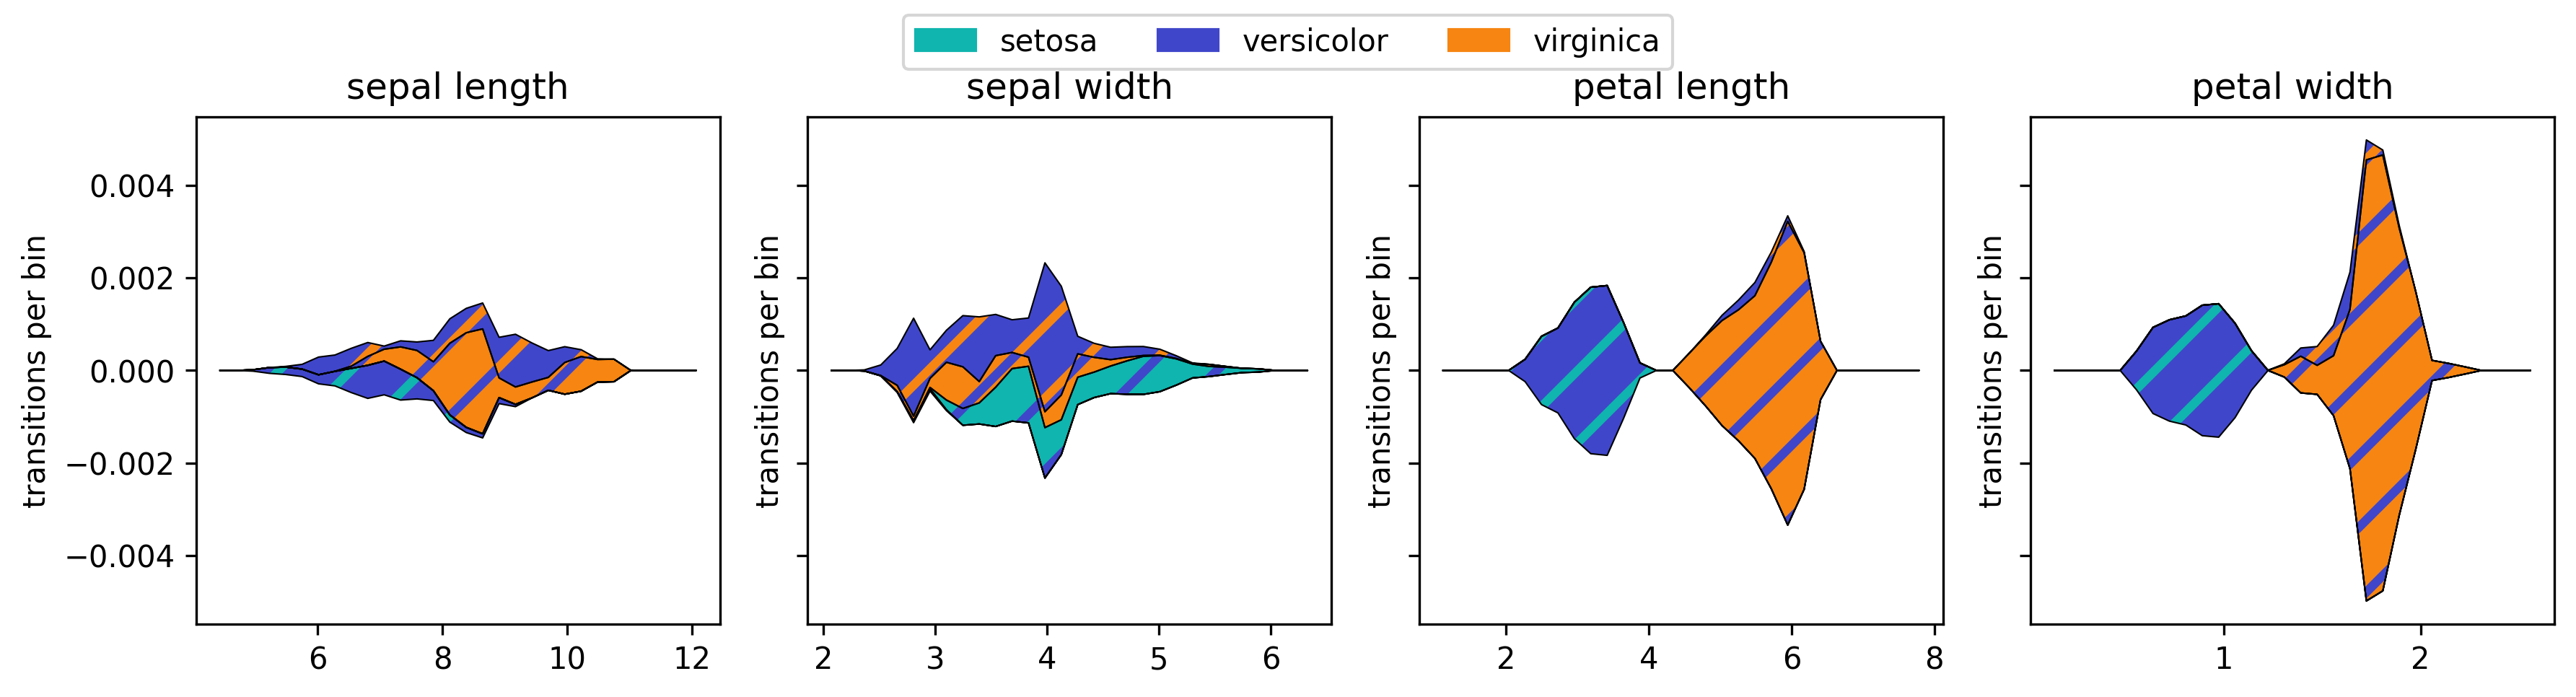

In [23]:
# plotting
_plot_sens_matrix_list_kwargs = dict(
        do_pairwise_labels=False, stackplot_fill=0, stackplot_color_hatch=True, stack_plot_kwargs=dict(baseline="sym", hatch="//", colors=label_colors), 
        stack_plot_gradient=False, horizontal_plot=True, stack_plot_outline=False, discrete_dimension_ticks_and_labels_kwargs=dict(rotation="vertical"),
        share_y_axis=True, stackplot_divider=True, fig_kwargs=dict(dpi=300), stackplot_hatch_linewidth=4,
        dim_labels=dim_labels, line_labels=label_names, title="Pairwise transitions divided by distribution"
    )
plot_sens_matrix_list_kwargs = dict(share_y_axis=True, stackplot_hatch_linewidth=3, 
                                                             stack_plot_kwargs=dict(baseline="sym", hatch="/", colors=label_colors),
                                                             title="", legend_kwargs=dict(ncol=3, loc="upper center"), fig_kwargs=dict(figsize=(12 * 1., 3 * 1.08)))
_plot_sens_matrix_list_kwargs.update(plot_sens_matrix_list_kwargs)
f = plot_sens_matrix_list(sample_points=rec_sample_points, sens_matrix_list=sens_matrix_list, **_plot_sens_matrix_list_kwargs)

In [39]:
import time

def bandwidth_experiment(n_samples_per_dim_: int, repeat: int = 10) -> tuple:
    timings = []
    
    for _ in range(repeat):
        start = time.time()
        bandwidths = (aabbox[:, 1] - aabbox[:, 0]) / n_samples_per_dim_
        sample_points_min_max = compute_sample_points(clip_box=aabbox, bandwidths=bandwidths, step_size=step_size)

        n_proc = None  # single-core

        ridge_based_para_sense_preparations_result = ridge_based_para_sense_preparations(ridge_vertices=ridge_vertices,
                                                                                         bandwidths=bandwidths,
                                                                                         clip_box=aabbox,
                                                                                         step_size=step_size,
                                                                                         sample_points_min_max=sample_points_min_max,
                                                                                         verbose=False)
        build_directed_transition_cubes_result = build_directed_transition_cubes(M_T, ridge_vertices, sample_points_min_max=sample_points_min_max, 
                                                     ridge_based_para_sense_preparations_result=ridge_based_para_sense_preparations_result,
                                                     bandwidths=bandwidths, clip_box=aabbox, step_size=step_size, n_proc=n_proc, verbose=False)

        _, dtc_ret = build_directed_transition_cubes_result
        sens_matrix_list = [d[0] for d in dtc_ret]
        n_ridge_matrix_list = [d[1] for d in dtc_ret]

        end = time.time()

        elapsed = end - start

        timings.append(elapsed)
    
    # reconstruct sample points for non-discrete values
    if not normalize_samples:
        rec_sample_points = sample_points_min_max[0]
    else:
        rec_sample_points = [sp * maxs[dim] + mins[dim] if dim not in discrete_dims else sp for dim, sp in enumerate(sample_points_min_max[0])]

    # plotting
    _plot_sens_matrix_list_kwargs = dict(
        do_pairwise_labels=False, stackplot_fill=0, stackplot_color_hatch=True, stack_plot_kwargs=dict(baseline="sym", hatch="//", colors=label_colors), 
        stack_plot_gradient=False, horizontal_plot=True, stack_plot_outline=False, discrete_dimension_ticks_and_labels_kwargs=dict(rotation="vertical"),
        share_y_axis=True, stackplot_divider=True, fig_kwargs=dict(dpi=300), stackplot_hatch_linewidth=4,
        dim_labels=dim_labels, line_labels=label_names, title="Pairwise transitions divided by distribution"
    )
    plot_sens_matrix_list_kwargs = dict(share_y_axis=True, stackplot_hatch_linewidth=3, 
                                                             stack_plot_kwargs=dict(baseline="sym", hatch="/", colors=label_colors),
                                                             title="", legend_kwargs=dict(ncol=3, loc="upper center"), fig_kwargs=dict(figsize=(12 * 1., 3 * 1.08)))
    _plot_sens_matrix_list_kwargs.update(plot_sens_matrix_list_kwargs)
    print(f"n_samples_per_dim: {n_samples_per_dim_}, repeats: {repeat}, timings average: {np.average(timings):.2f}, std: {np.std(timings):.2f}, median: {np.median(timings):.2f}, bandwidths: {bandwidths.tolist()}")
    f = plot_sens_matrix_list(sample_points=rec_sample_points, sens_matrix_list=sens_matrix_list, **_plot_sens_matrix_list_kwargs)

    return timings, (sens_matrix_list, n_ridge_matrix_list, sample_points_min_max, rec_sample_points), _plot_sens_matrix_list_kwargs


n_samples_per_dim: 1, repeats: 10, timings average: 1.91, std: 0.05, median: 1.89, bandwidths: [1.0, 1.0, 1.0, 1.0]


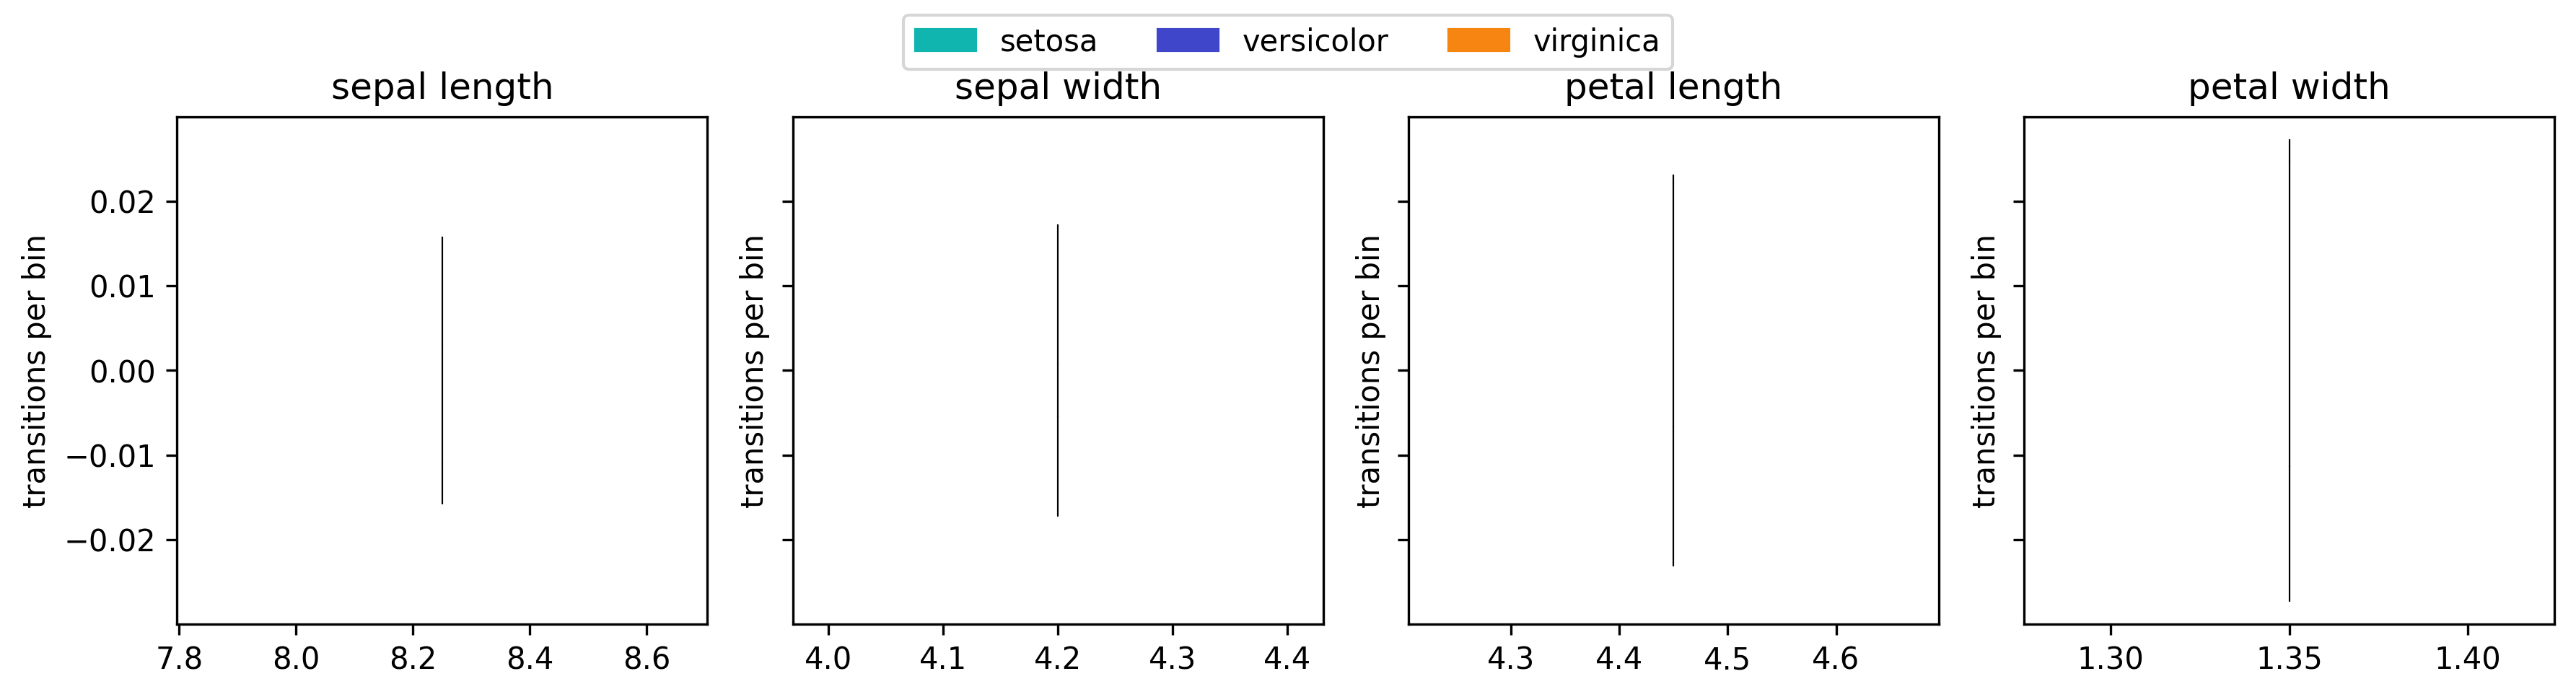

n_samples_per_dim: 2, repeats: 10, timings average: 2.18, std: 0.09, median: 2.16, bandwidths: [0.5, 0.5, 0.5, 0.5]


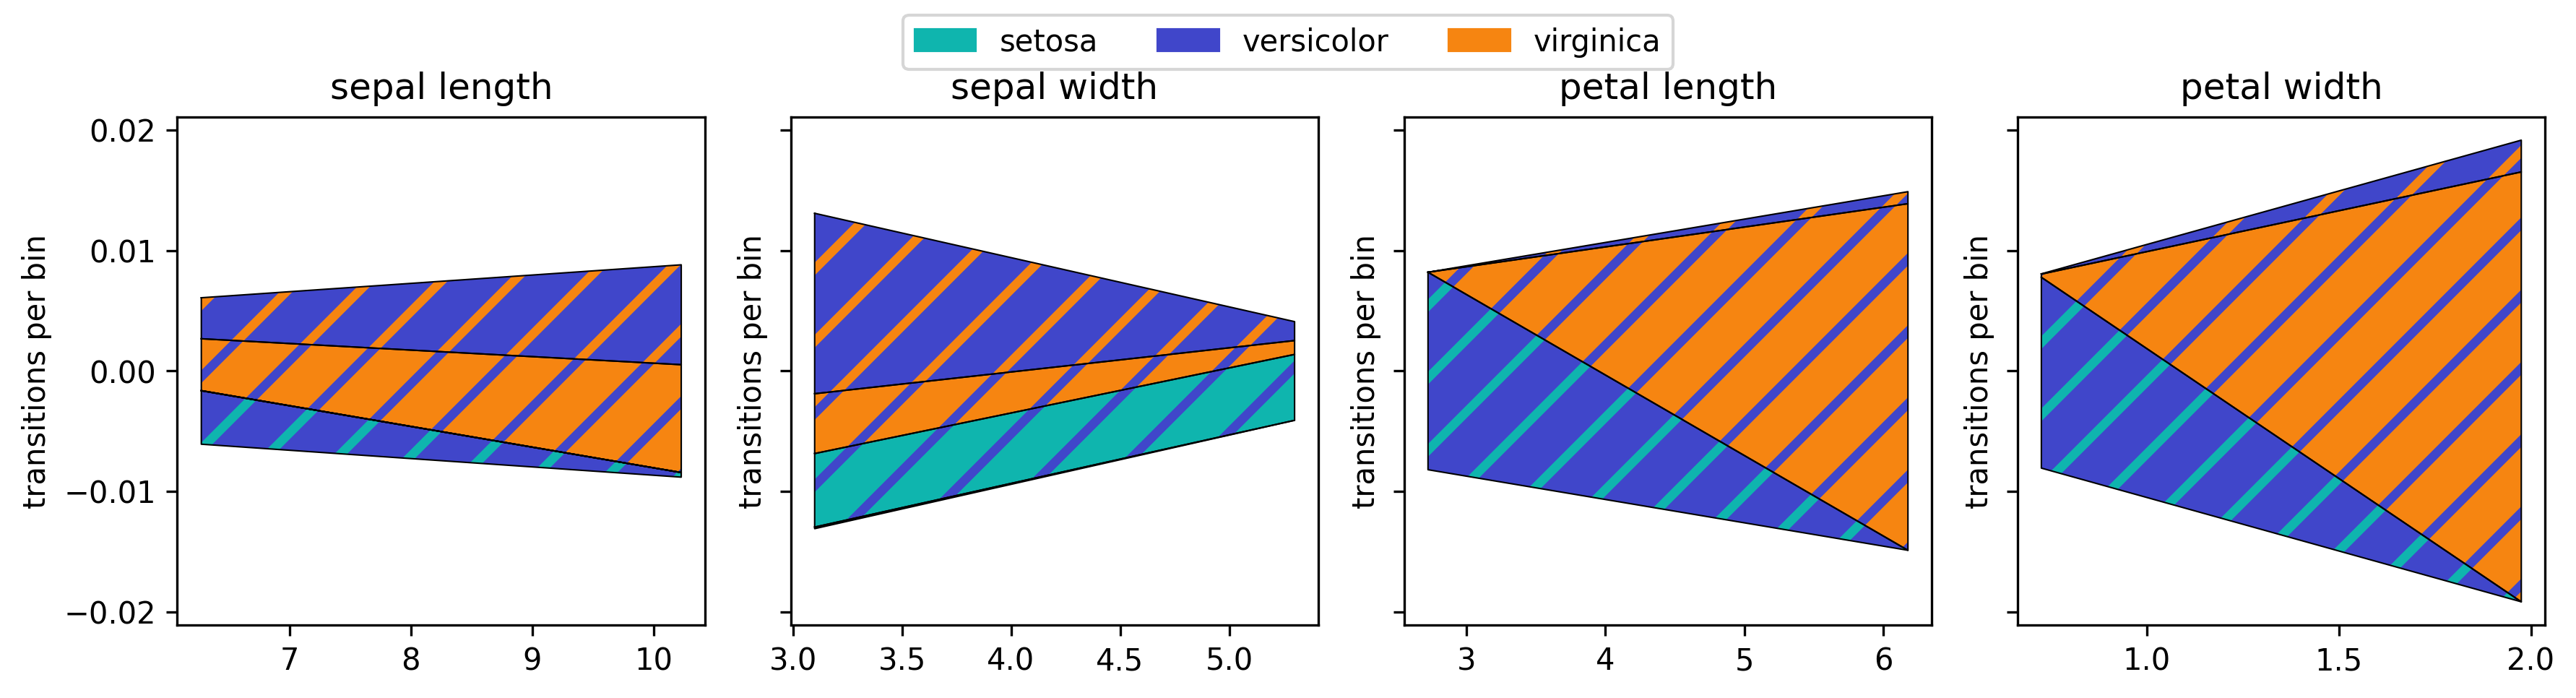

n_samples_per_dim: 4, repeats: 10, timings average: 2.51, std: 0.05, median: 2.48, bandwidths: [0.25, 0.25, 0.25, 0.25]


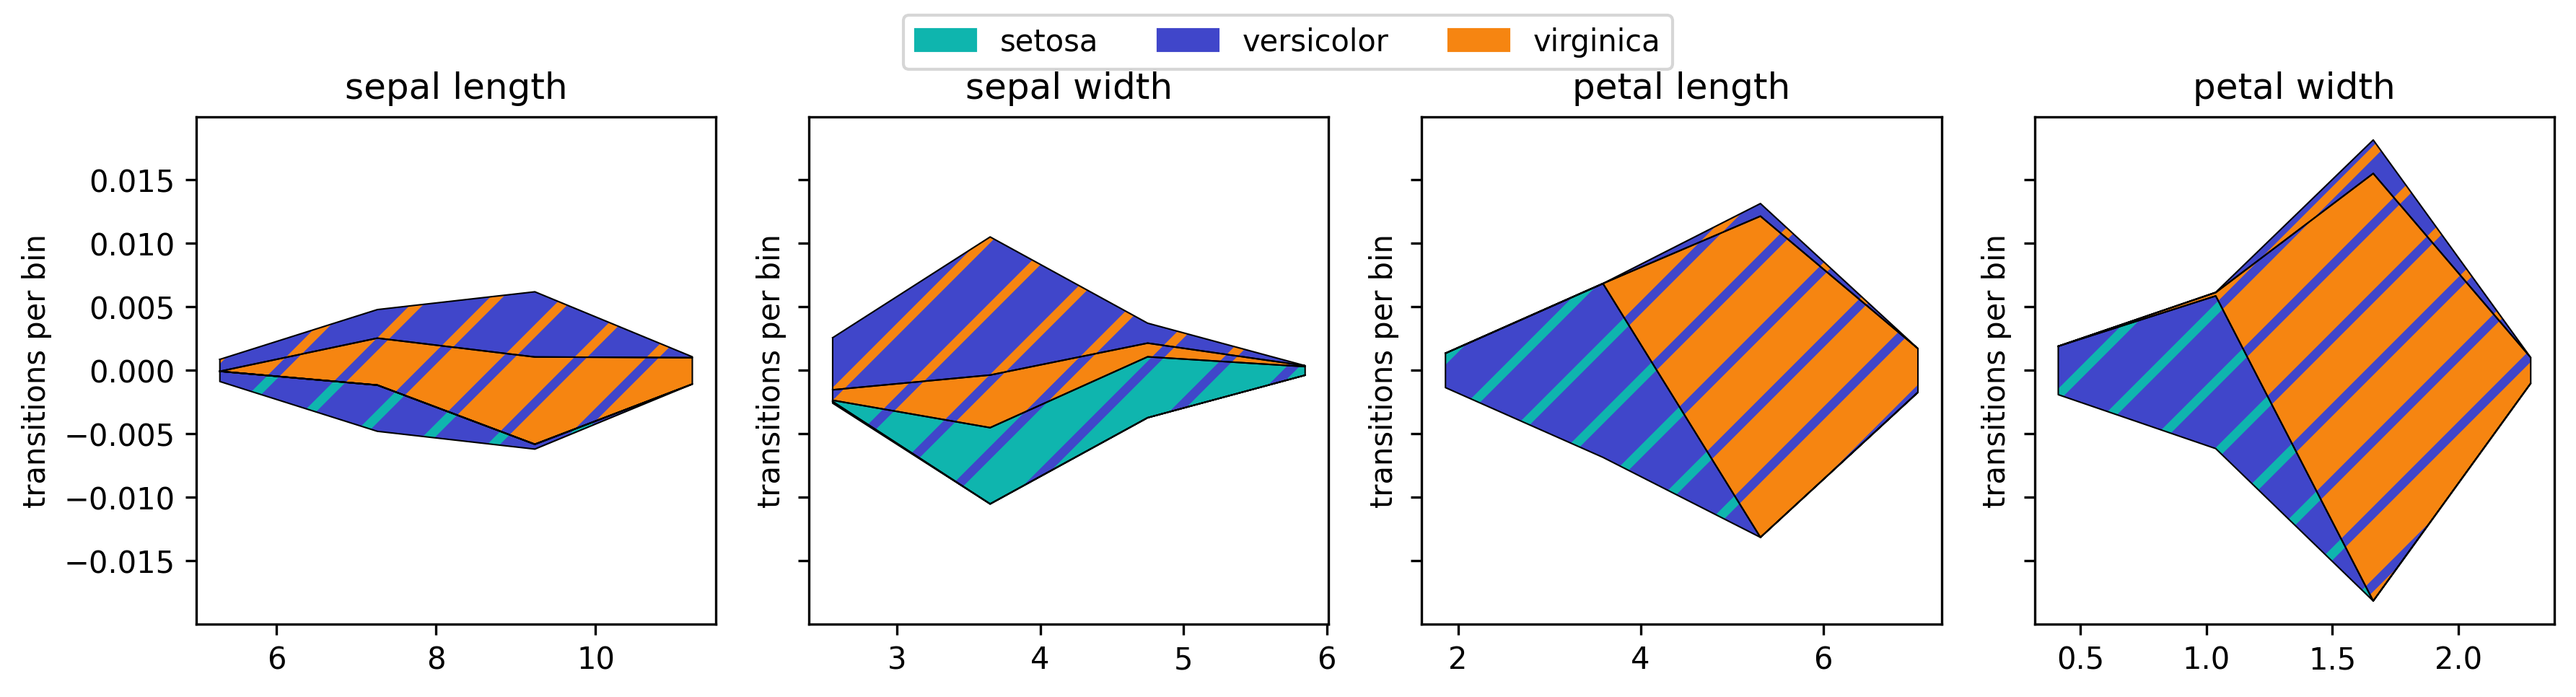

n_samples_per_dim: 8, repeats: 10, timings average: 3.23, std: 0.19, median: 3.23, bandwidths: [0.125, 0.125, 0.125, 0.125]


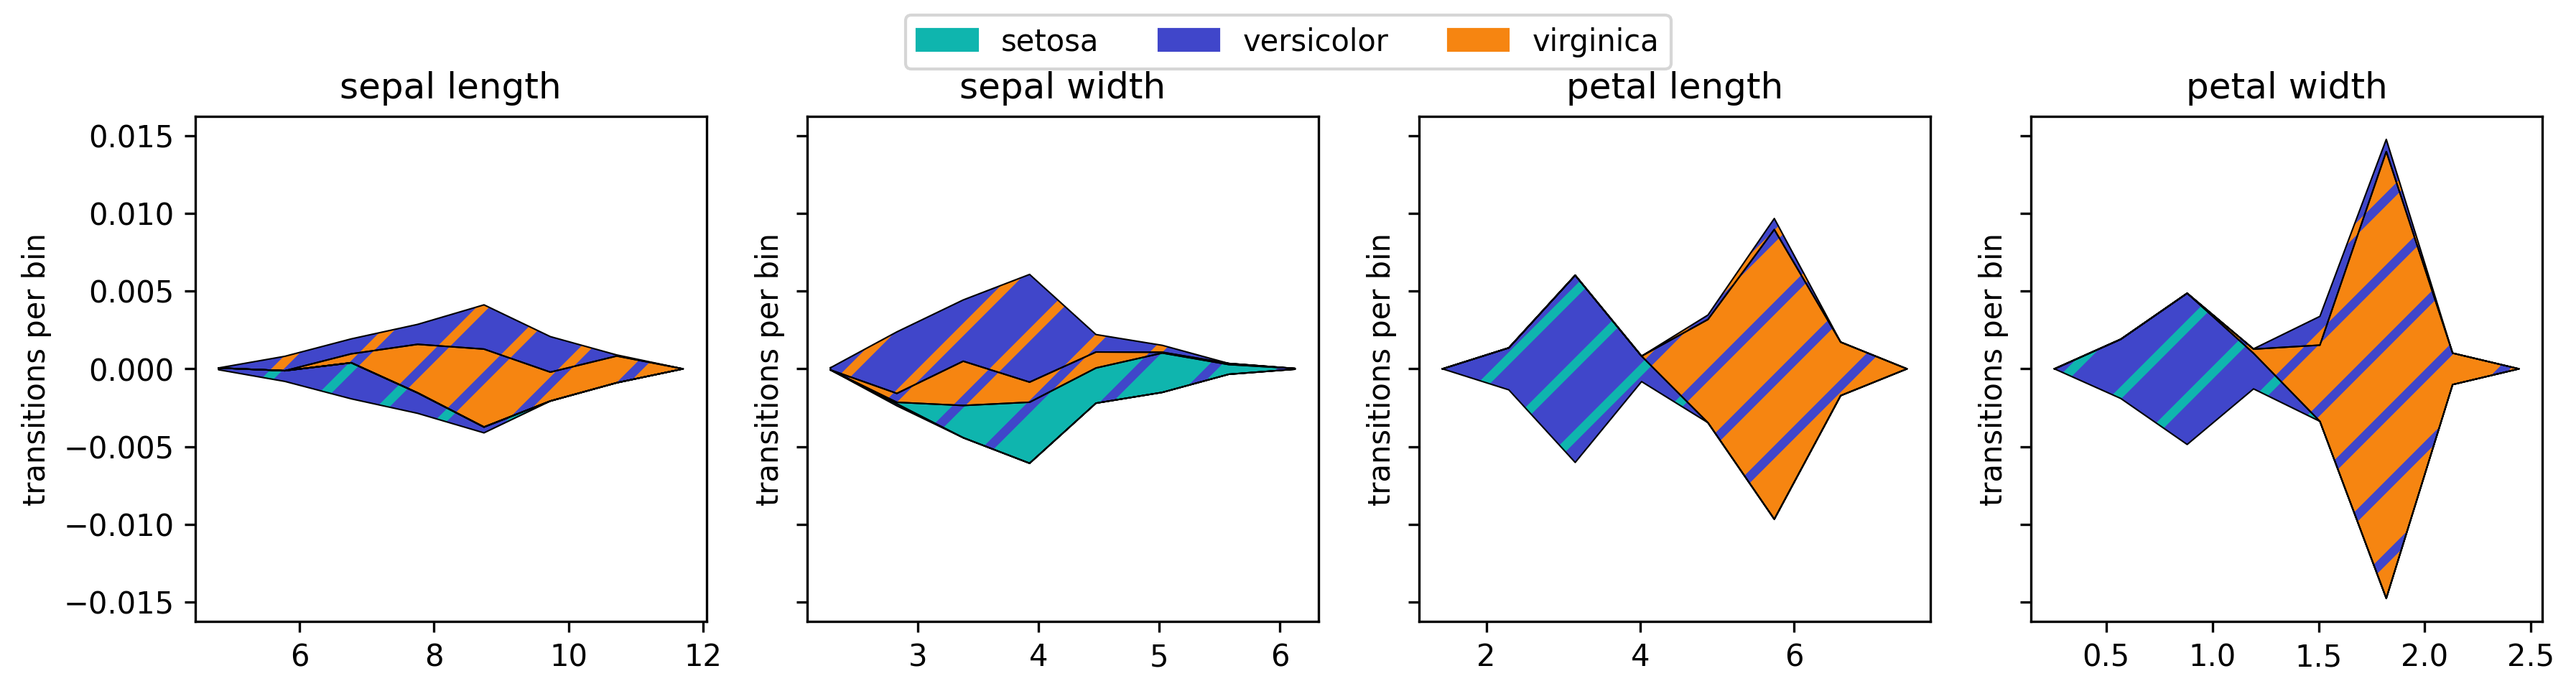

n_samples_per_dim: 16, repeats: 10, timings average: 4.68, std: 0.18, median: 4.64, bandwidths: [0.0625, 0.0625, 0.0625, 0.0625]


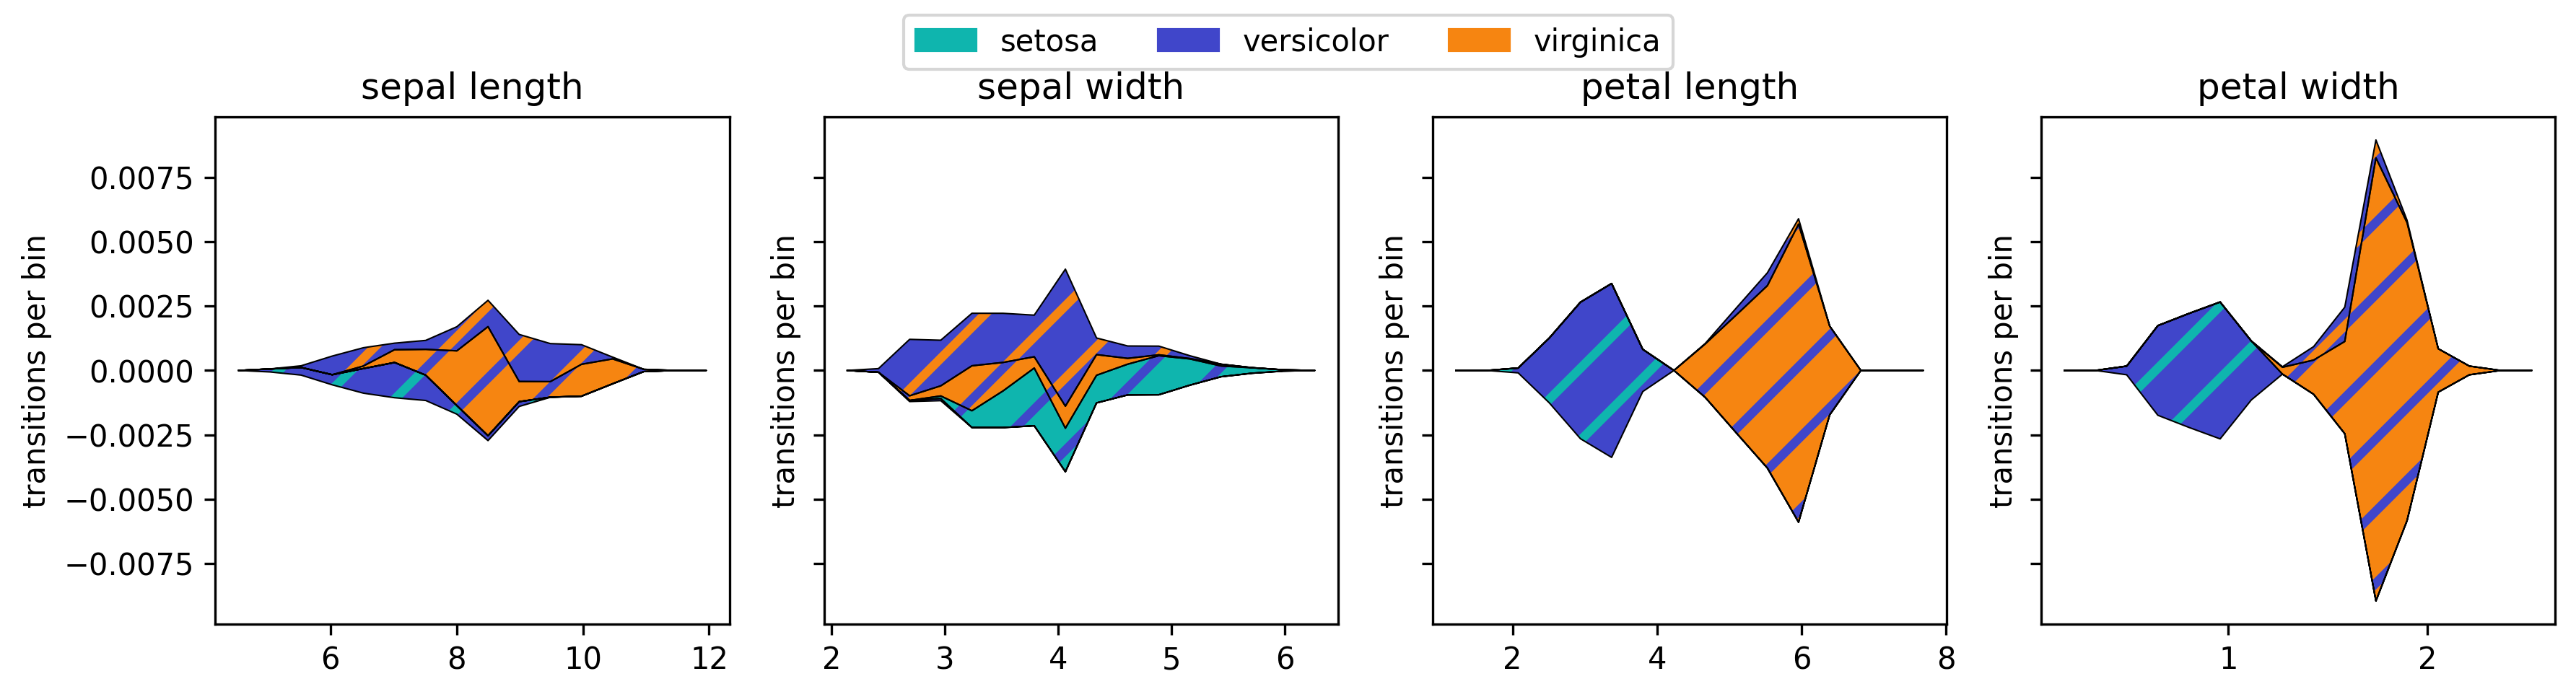

n_samples_per_dim: 32, repeats: 10, timings average: 7.77, std: 0.51, median: 7.60, bandwidths: [0.03125, 0.03125, 0.03125, 0.03125]


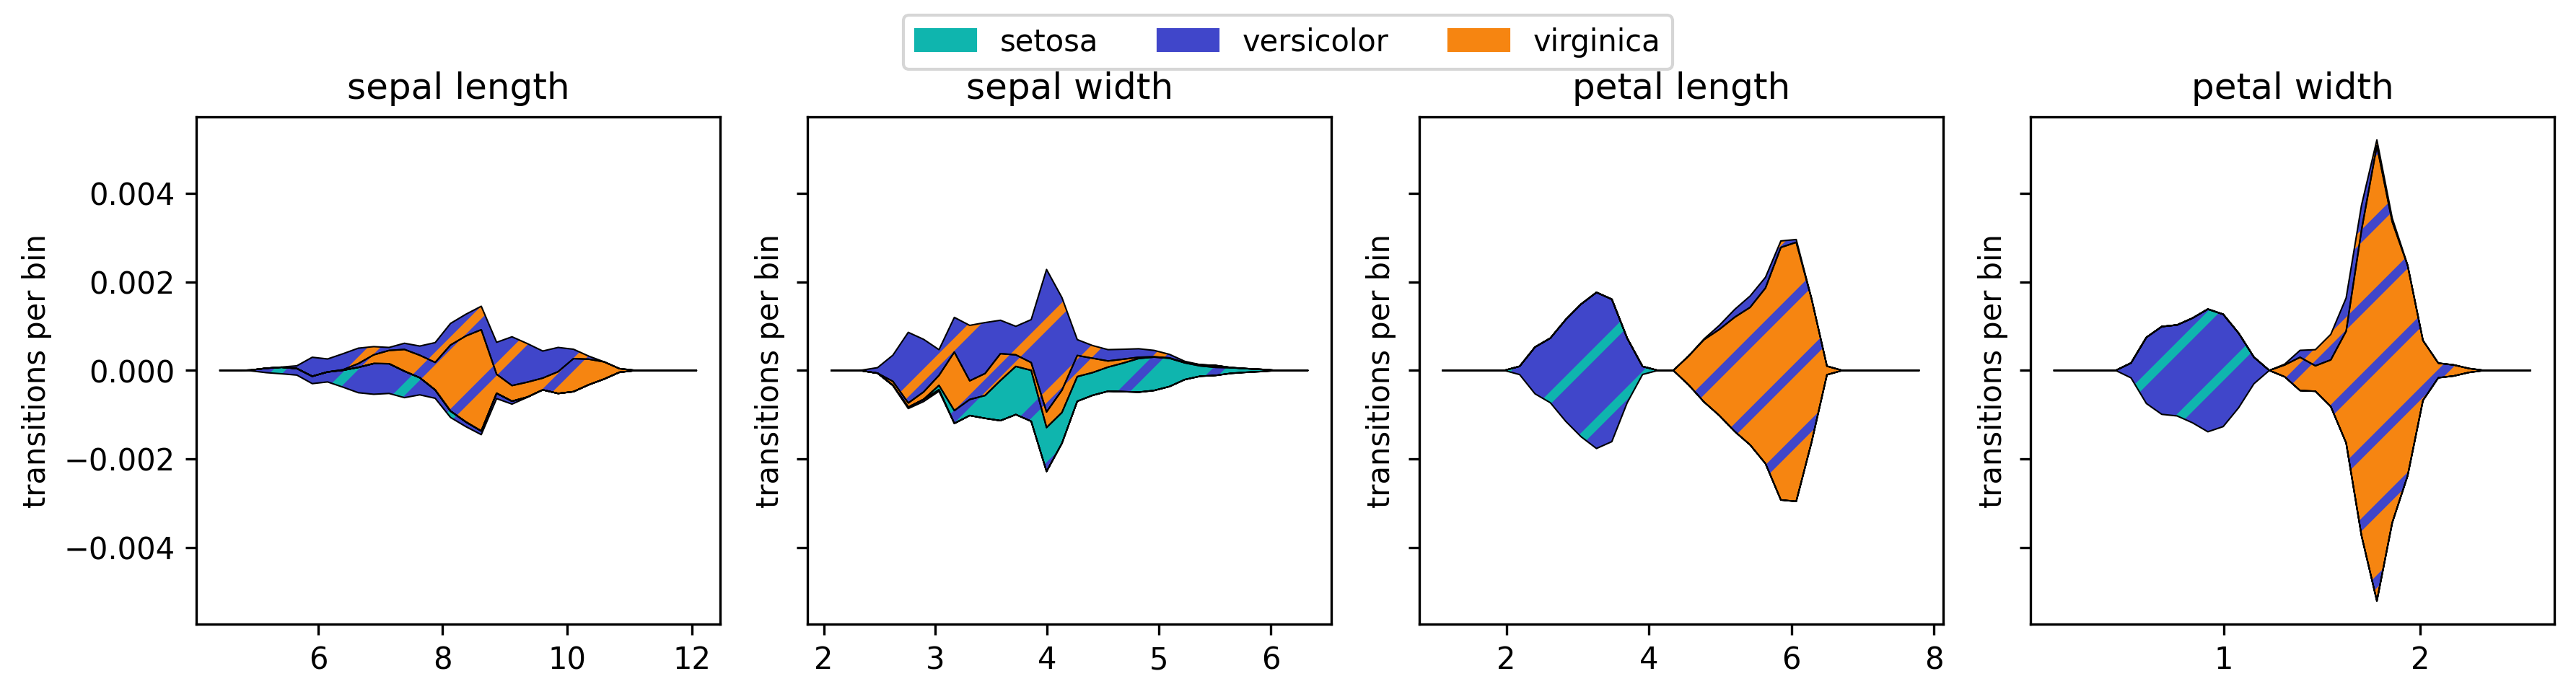

n_samples_per_dim: 64, repeats: 10, timings average: 11.49, std: 0.51, median: 11.23, bandwidths: [0.015625, 0.015625, 0.015625, 0.015625]


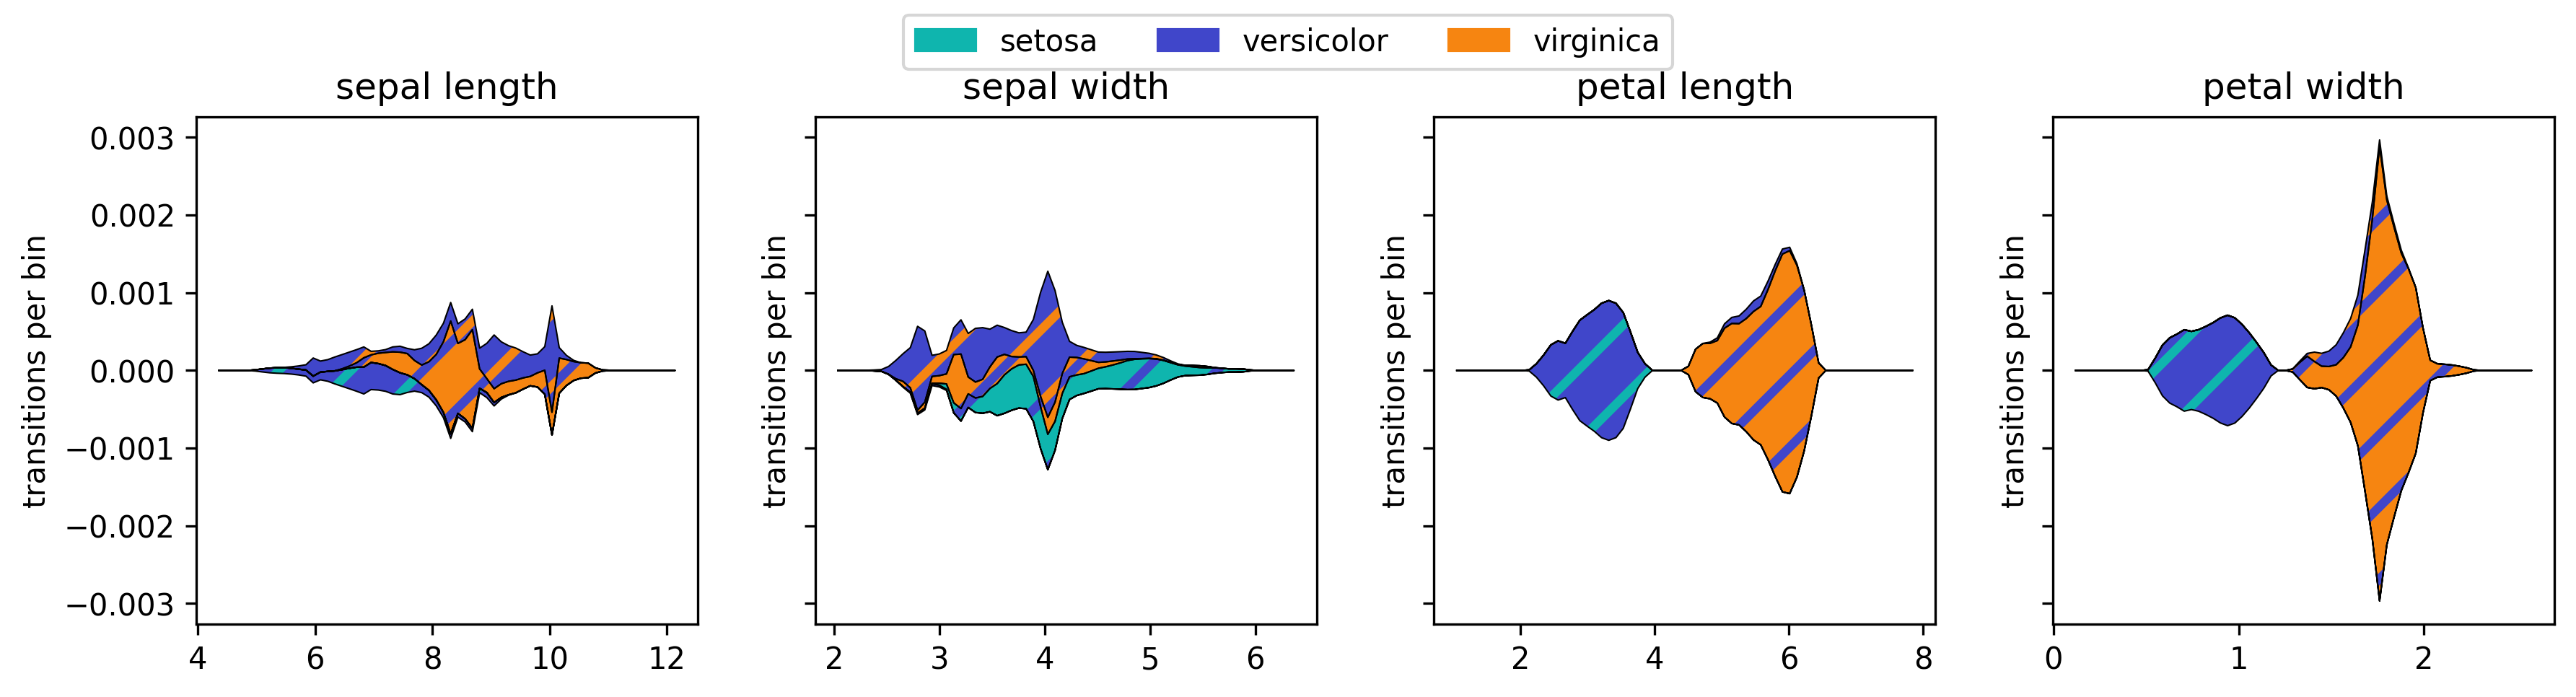

n_samples_per_dim: 128, repeats: 10, timings average: 21.77, std: 0.81, median: 21.59, bandwidths: [0.0078125, 0.0078125, 0.0078125, 0.0078125]


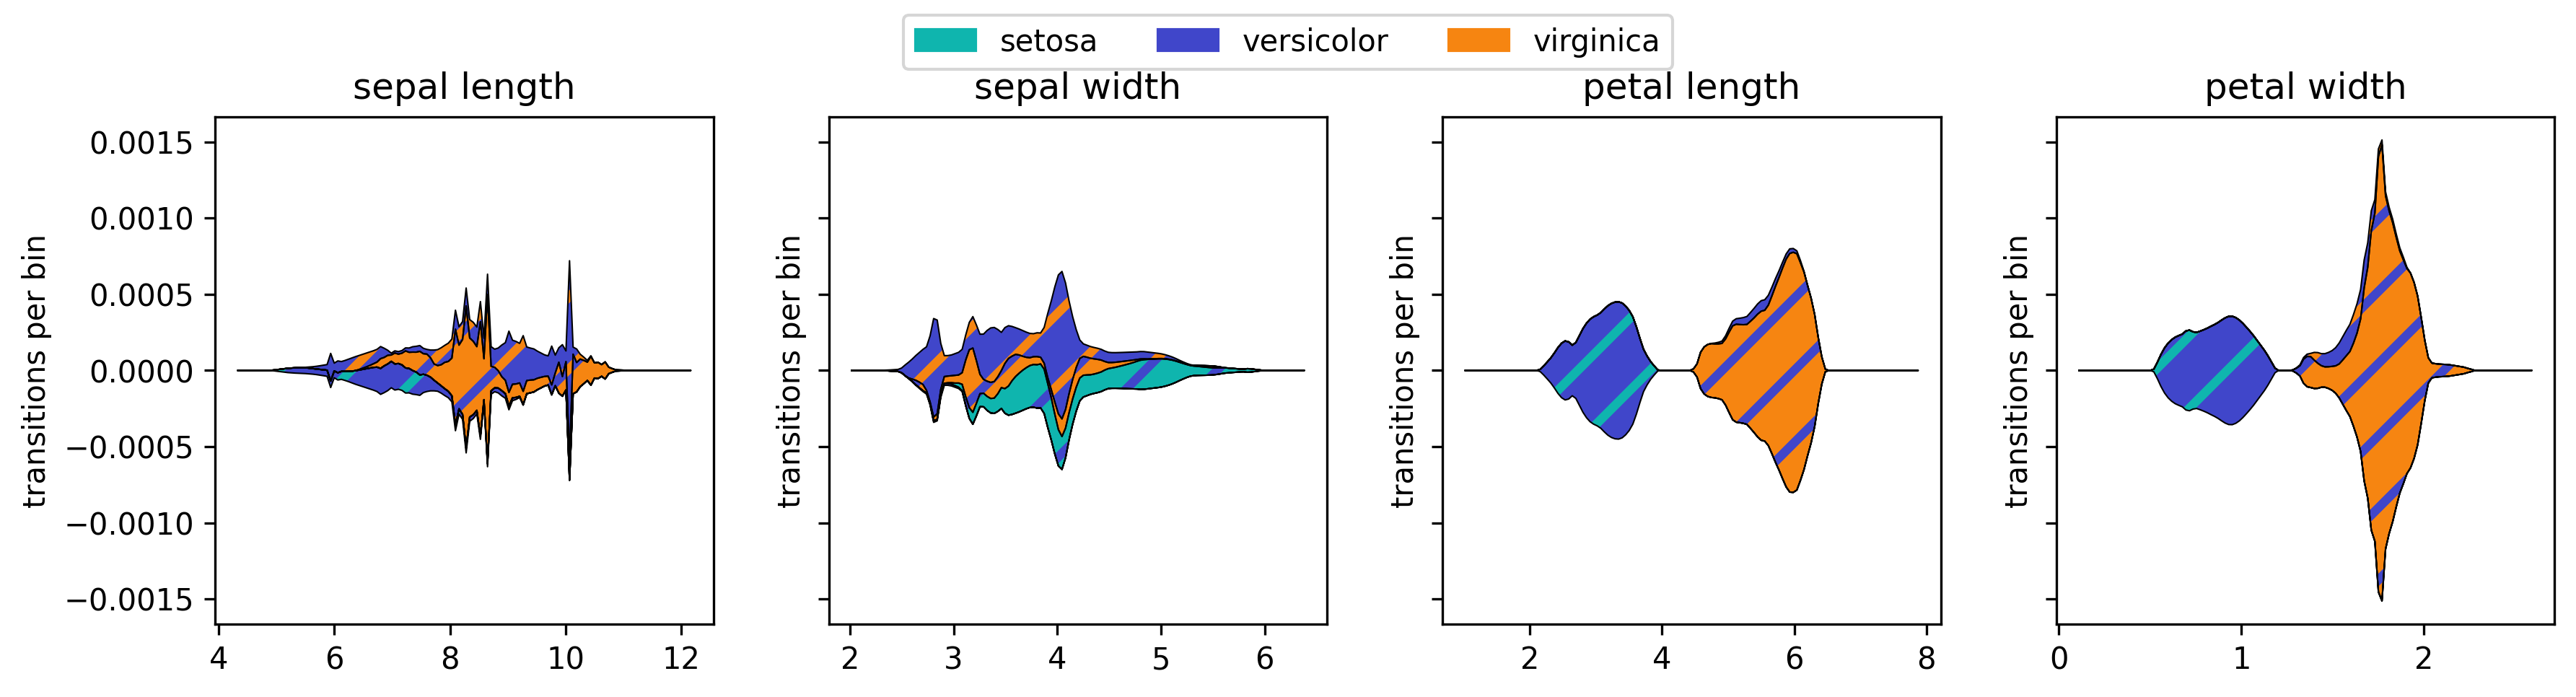

n_samples_per_dim: 256, repeats: 10, timings average: 44.07, std: 1.69, median: 44.53, bandwidths: [0.00390625, 0.00390625, 0.00390625, 0.00390625]


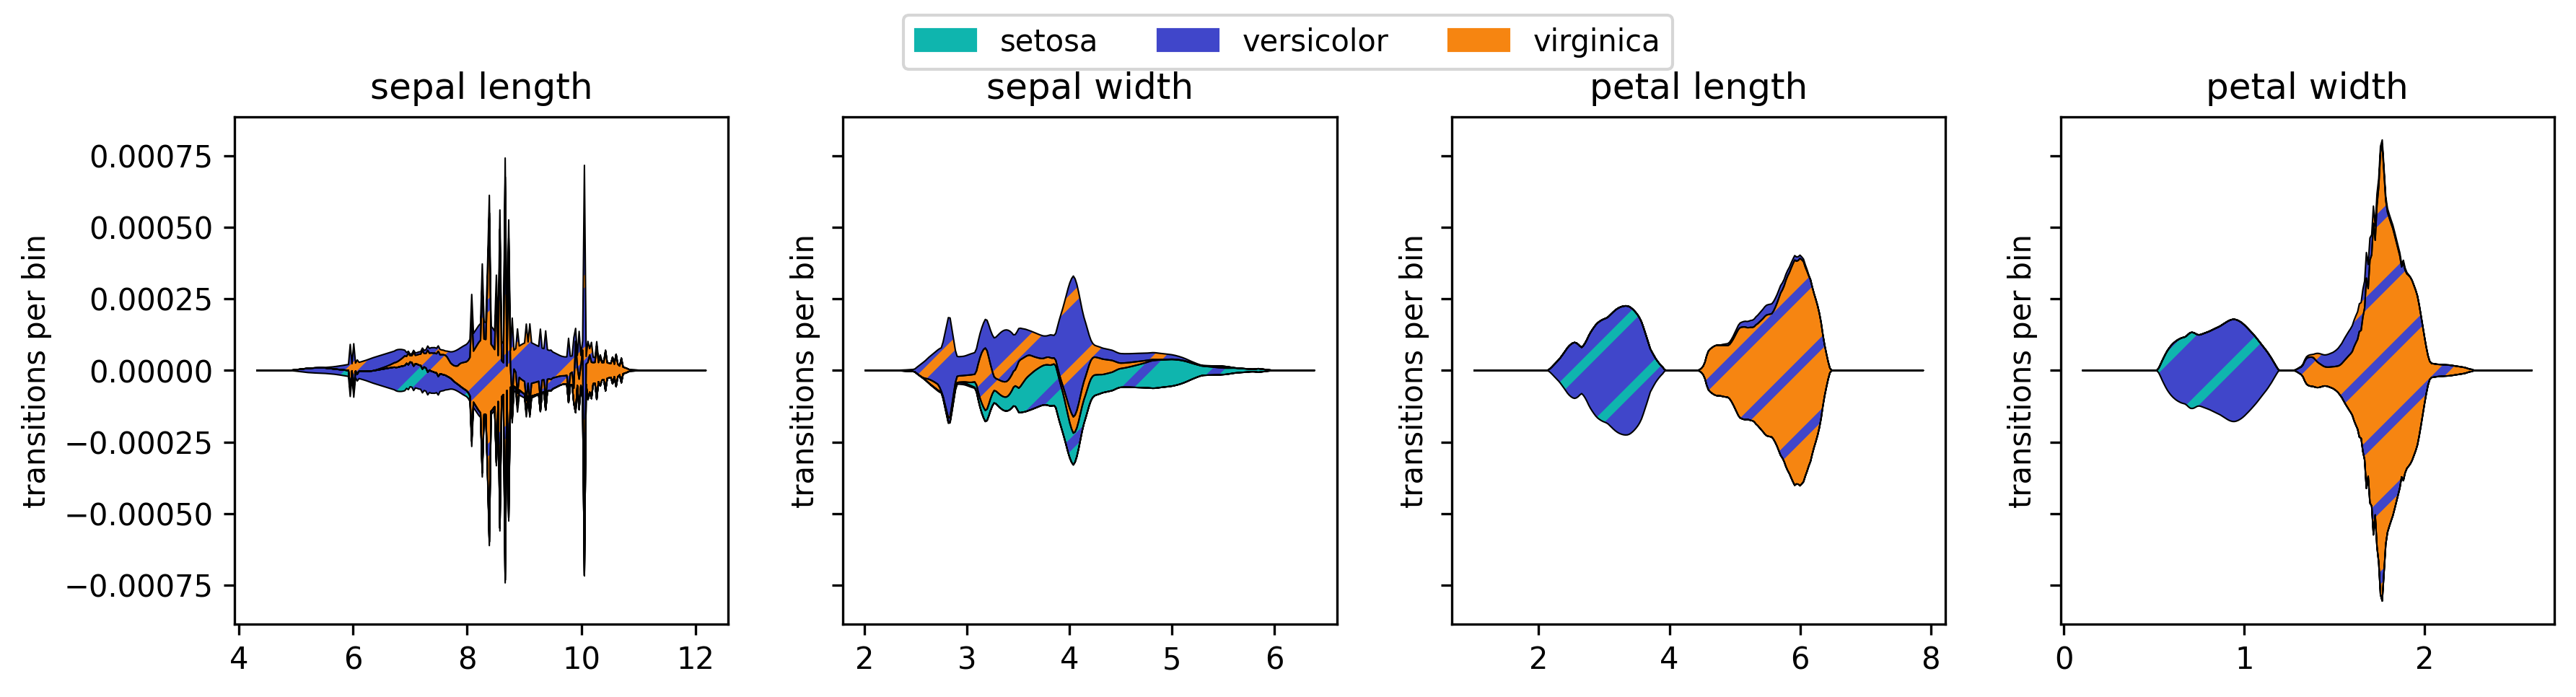

n_samples_per_dim: 512, repeats: 10, timings average: 90.37, std: 3.68, median: 89.34, bandwidths: [0.001953125, 0.001953125, 0.001953125, 0.001953125]


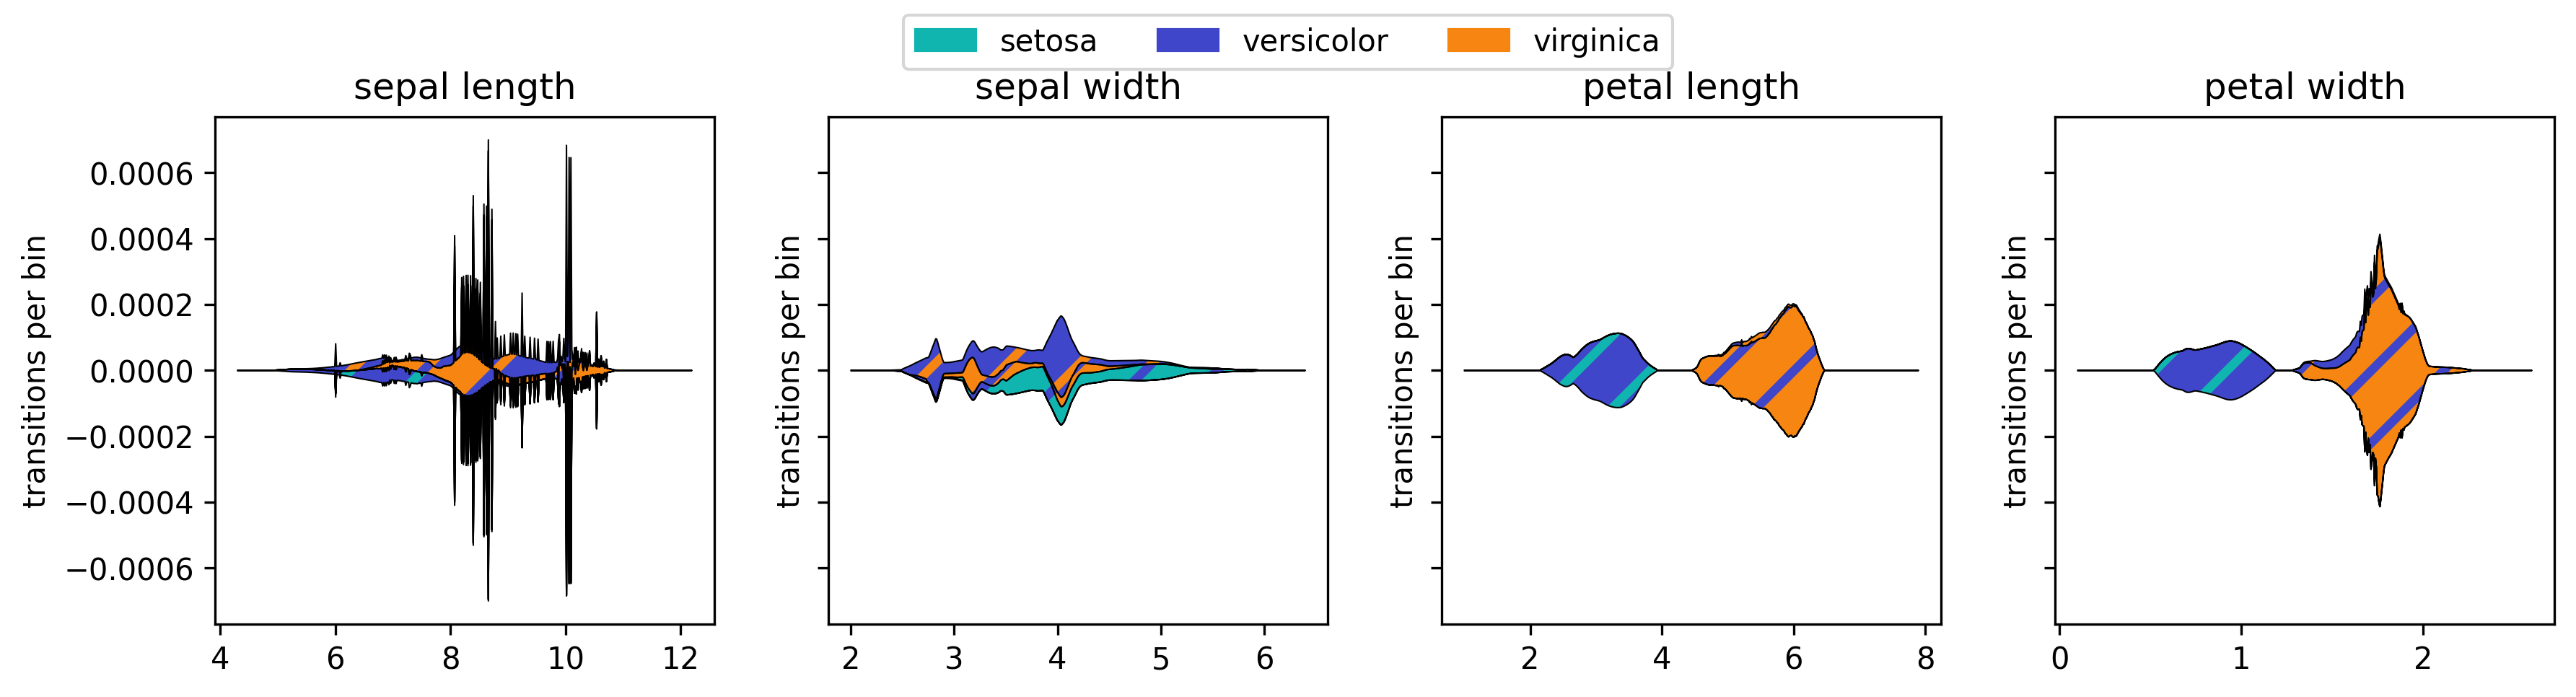

In [40]:
# bandwidth experiment
res = []

for n_samples_per_dim_ in [(2 ** i) for i in range(10)]:
    res_ = bandwidth_experiment(n_samples_per_dim_, repeat=10)
    res.append((n_samples_per_dim_, res_))

In [46]:
[r[0] for r in res], [r[1][0] for r in res]

([1, 2, 4, 8, 16, 32, 64, 128, 256, 512],
 [[1.9646837711334229,
   1.863595962524414,
   1.9413185119628906,
   1.8585147857666016,
   1.8906521797180176,
   1.855968952178955,
   2.0208218097686768,
   1.8940644264221191,
   1.8782398700714111,
   1.9130899906158447],
  [2.0791778564453125,
   2.1673948764801025,
   2.1593875885009766,
   2.105872631072998,
   2.395813465118408,
   2.121347188949585,
   2.2593588829040527,
   2.222243309020996,
   2.159367322921753,
   2.1426241397857666],
  [2.604137897491455,
   2.575355291366577,
   2.508652448654175,
   2.4603092670440674,
   2.5756778717041016,
   2.481463670730591,
   2.460564374923706,
   2.4791300296783447,
   2.4860451221466064,
   2.44734525680542],
  [3.2696518898010254,
   3.2317819595336914,
   3.232227087020874,
   3.175459146499634,
   3.162388801574707,
   3.354546546936035,
   3.6612138748168945,
   3.0099997520446777,
   2.905390501022339,
   3.299760341644287],
  [4.405481815338135,
   4.9108686447143555,
   4.8137

C:\Users\bauerrn\AppData\Local\Temp\ipykernel_30732\2634761152.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


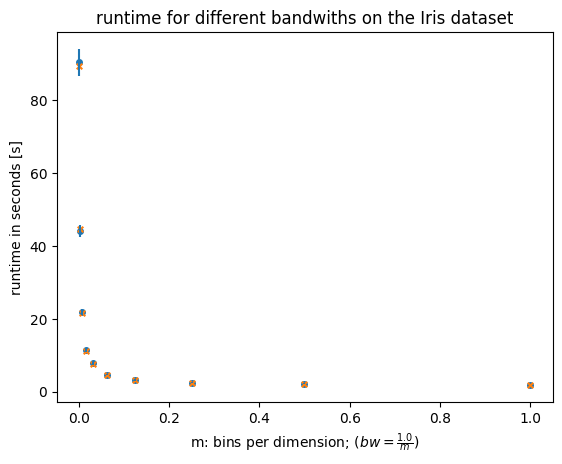

In [70]:
fig, ax = plt.subplots()

x = [r[0] for r in res]
bws = 1 / np.array(x)

ys = np.stack([r[1][0] for r in res])
avgs = np.average(ys, 1)
mds = np.median(ys, 1)
stds = np.std(ys, 1)

x = bws

ax.scatter(x, avgs, s=2**4)
ax.scatter(x, mds, s=2**4, marker="x")
ax.errorbar(x, avgs, yerr=stds, fmt='none')


ax.set_xlabel(r"m: bins per dimension; ($bw = \frac{1.0}{m}$)")
ax.set_ylabel("runtime in seconds [s]")

ax.set_title("runtime for different bandwiths on the Iris dataset")

fig.show()

C:\Users\bauerrn\AppData\Local\Temp\ipykernel_30732\1957915761.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


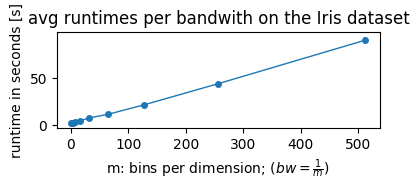

In [93]:
fig = plt.figure(figsize=(4, 2))
ax = fig.gca()

x = [r[0] for r in res]
bws = 1 / np.array(x)

ys = np.stack([r[1][0] for r in res])
avgs = np.average(ys, 1)
mds = np.median(ys, 1)
stds = np.std(ys, 1)

ax.plot(x, avgs, linewidth=1)
ax.scatter(x, avgs, s=2**4)
# ax.scatter(x, mds, s=2**4, marker="x")
ax.errorbar(x, avgs, yerr=stds, fmt='none')


ax.set_xlabel(r"m: bins per dimension; ($bw = \frac{1}{m}$)")
ax.set_ylabel("runtime in seconds [s]")

ax.set_title("avg runtimes per bandwith on the Iris dataset")

fig.tight_layout()
fig.show()
fig.savefig("bandwidth_experiments.pdf")

In [72]:
import pickle

In [73]:
with open("tmp_bandwidth_experiments_res.pkl", "wb") as f:
    pickle.dump(res, f)

In [94]:
_plot_sens_matrix_list_kwargs = dict(
        do_pairwise_labels=False, stackplot_fill=0, stackplot_color_hatch=True, stack_plot_kwargs=dict(baseline="sym", hatch="//", colors=label_colors), 
        stack_plot_gradient=False, horizontal_plot=True, stack_plot_outline=False, discrete_dimension_ticks_and_labels_kwargs=dict(rotation="vertical"),
        share_y_axis=True, stackplot_divider=True, fig_kwargs=dict(dpi=300), stackplot_hatch_linewidth=4,
        dim_labels=dim_labels, line_labels=label_names, title="Pairwise transitions divided by distribution"
    )
plot_sens_matrix_list_kwargs = dict(share_y_axis=True, stackplot_hatch_linewidth=3, 
                                                             stack_plot_kwargs=dict(baseline="sym", hatch="/", colors=label_colors),
                                                             title="", legend_kwargs=dict(ncol=3, loc="upper center"), fig_kwargs=dict(figsize=(12 * 1., 3 * 1.08)))
_plot_sens_matrix_list_kwargs.update(plot_sens_matrix_list_kwargs)

In [95]:
_save_fig_kwargs = dict(
        bbox_inches="tight"
    )

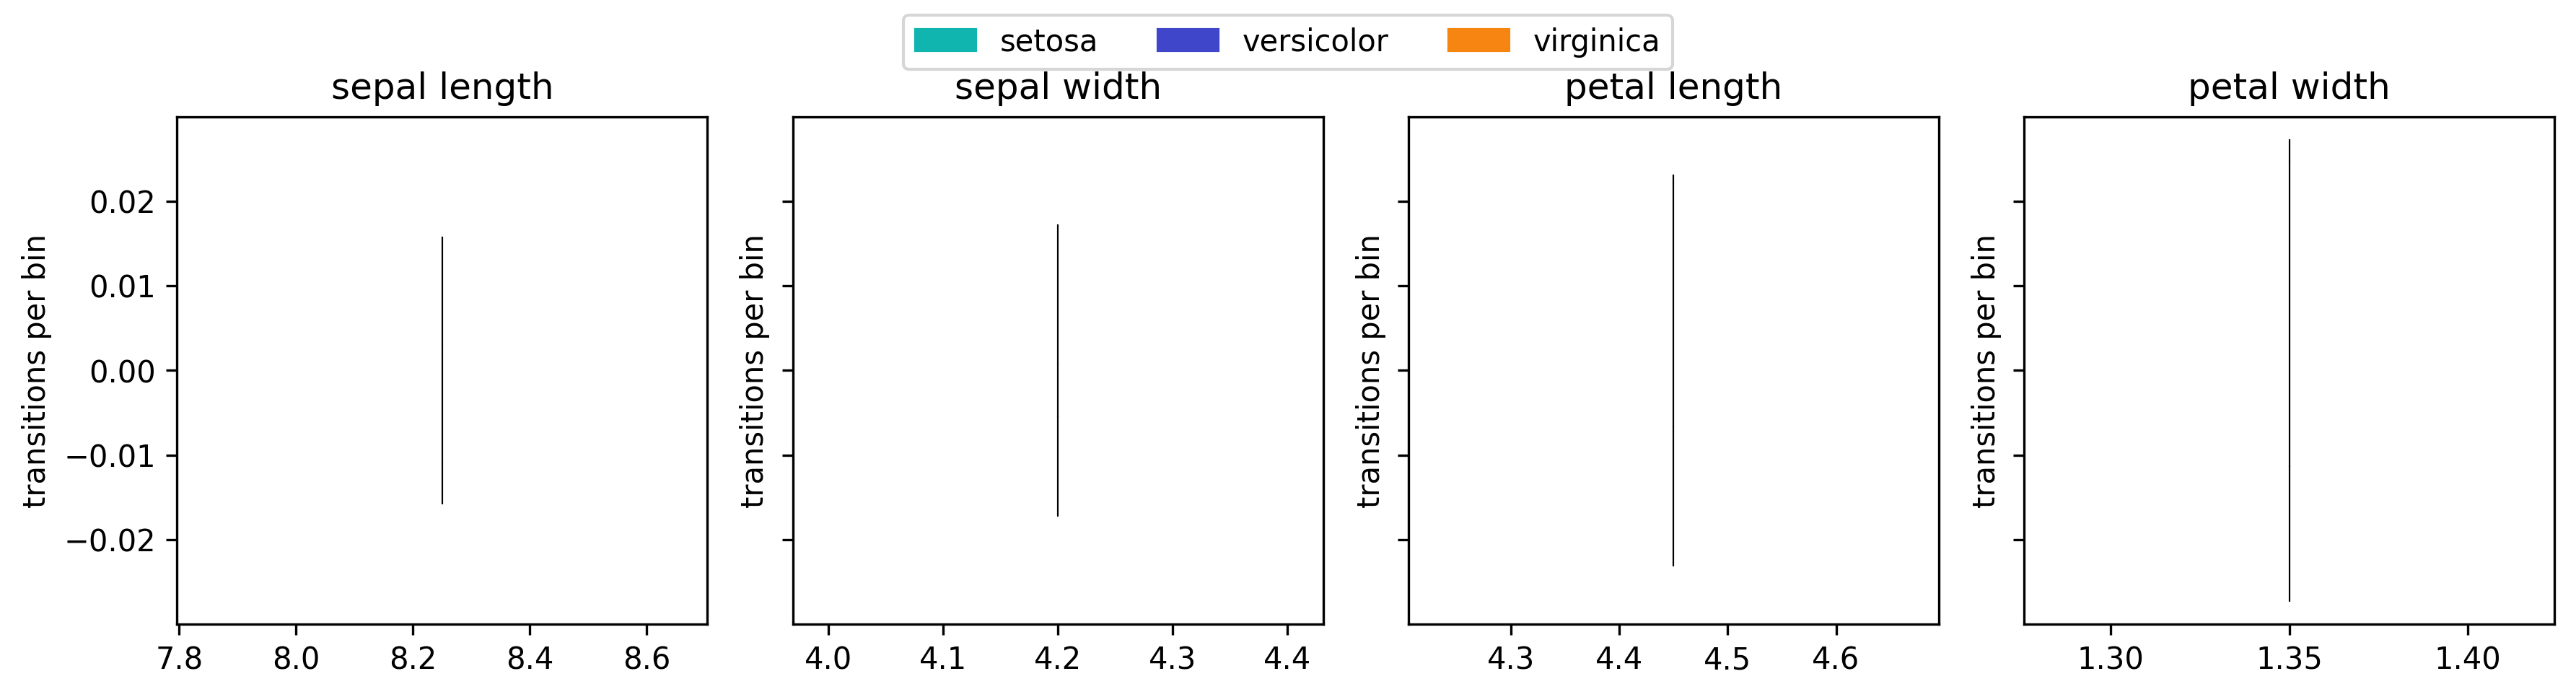

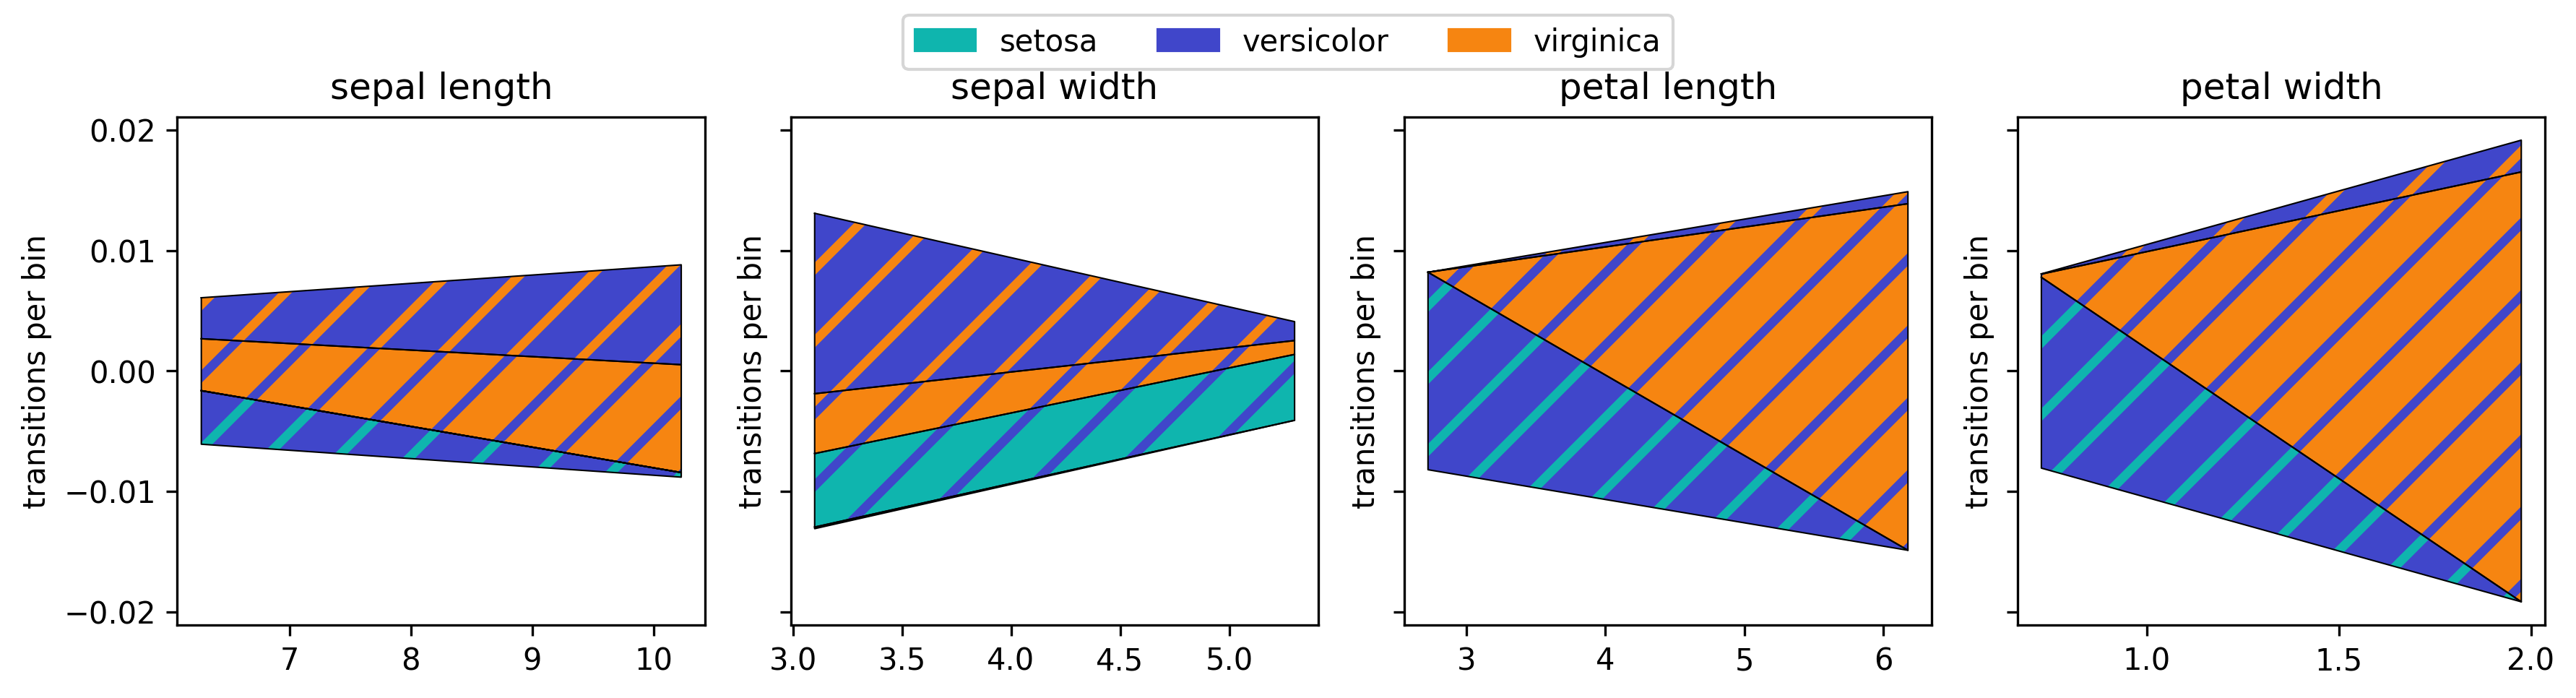

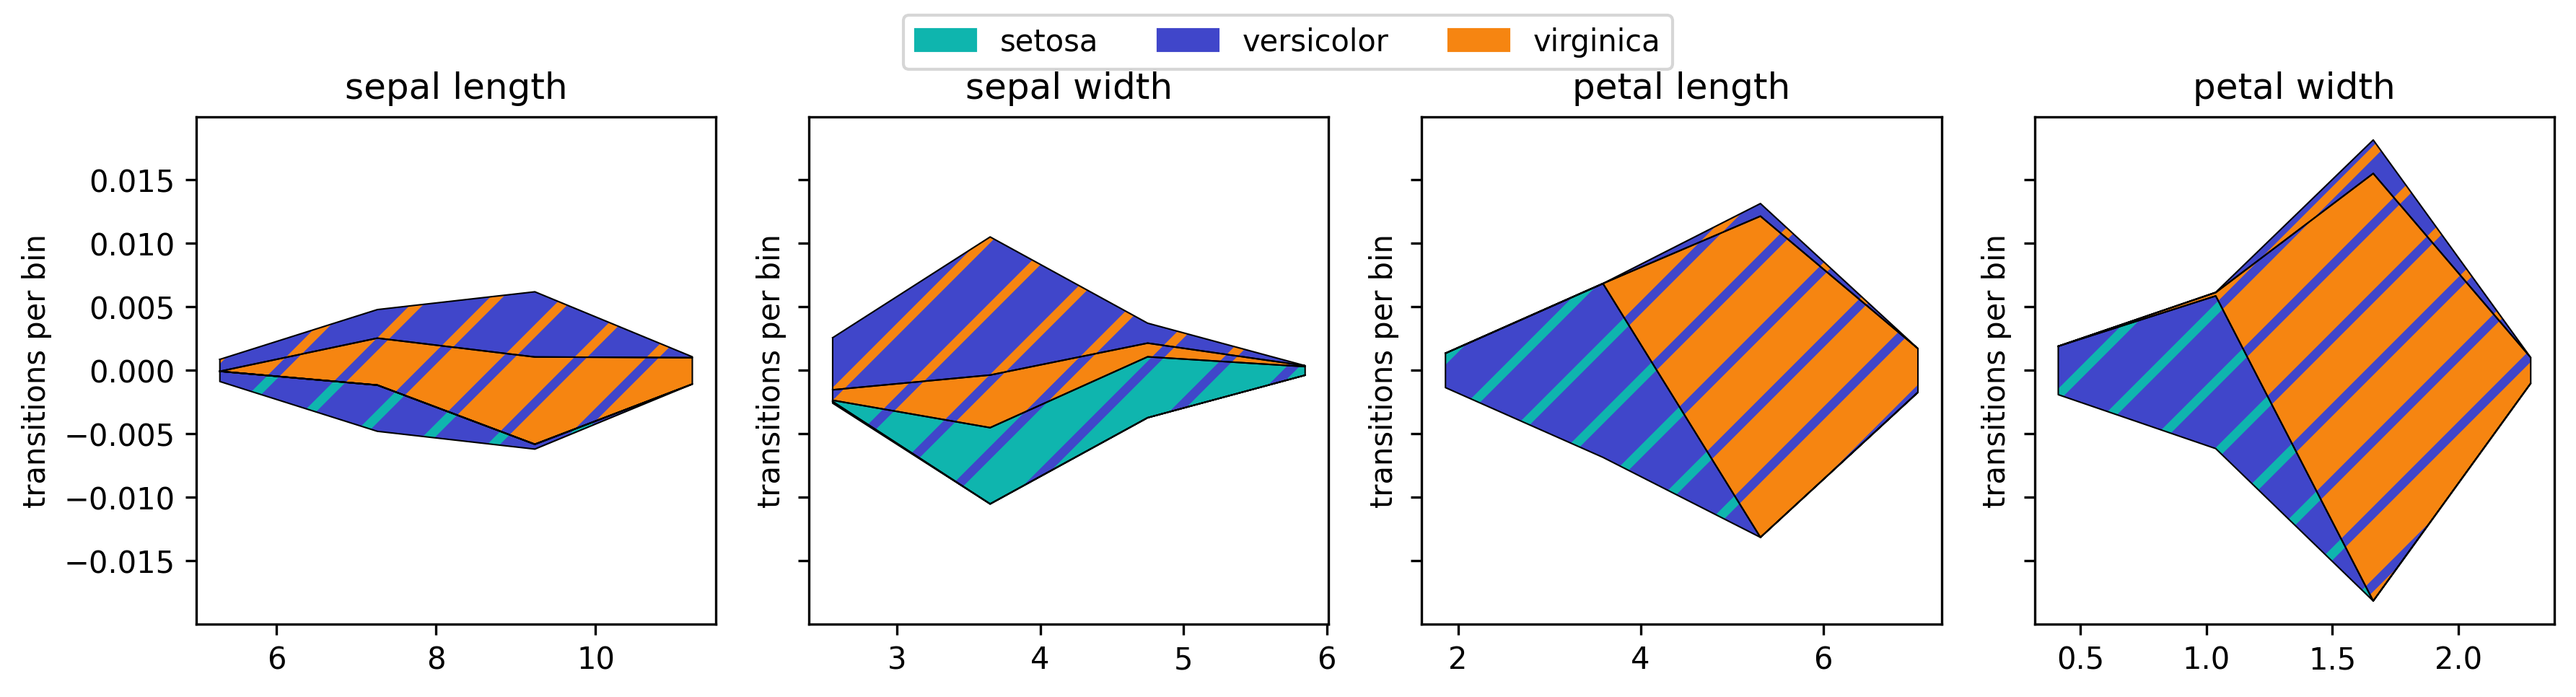

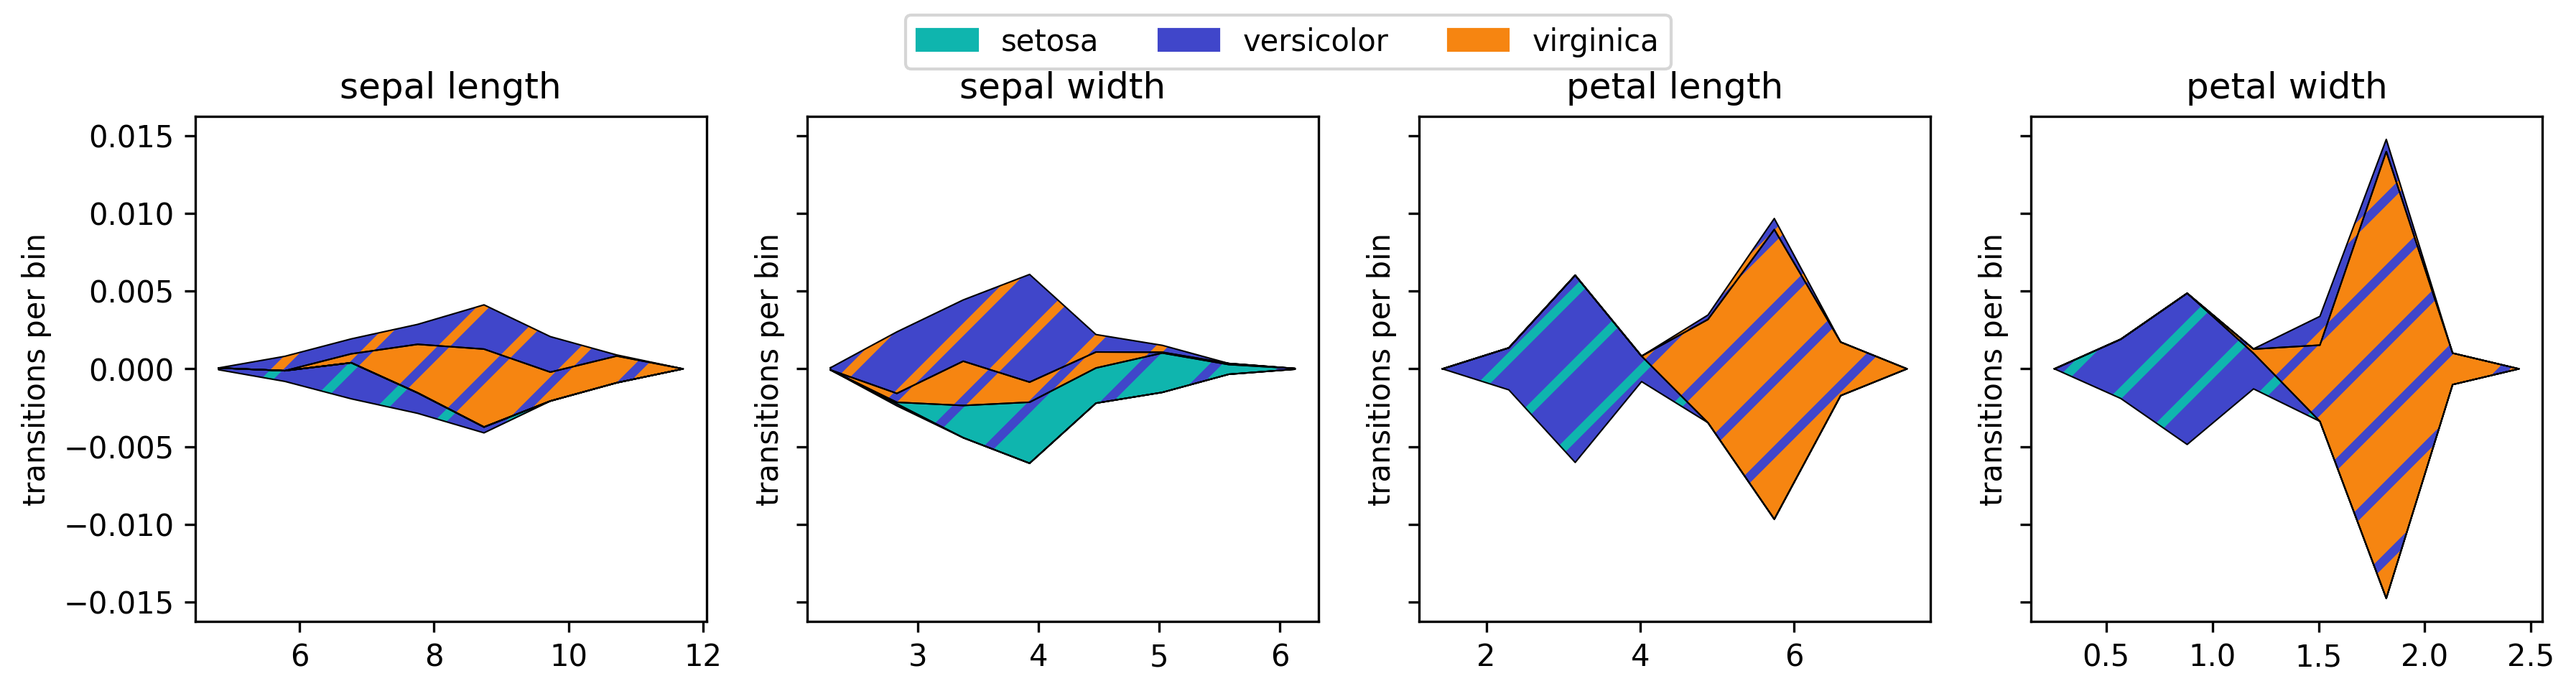

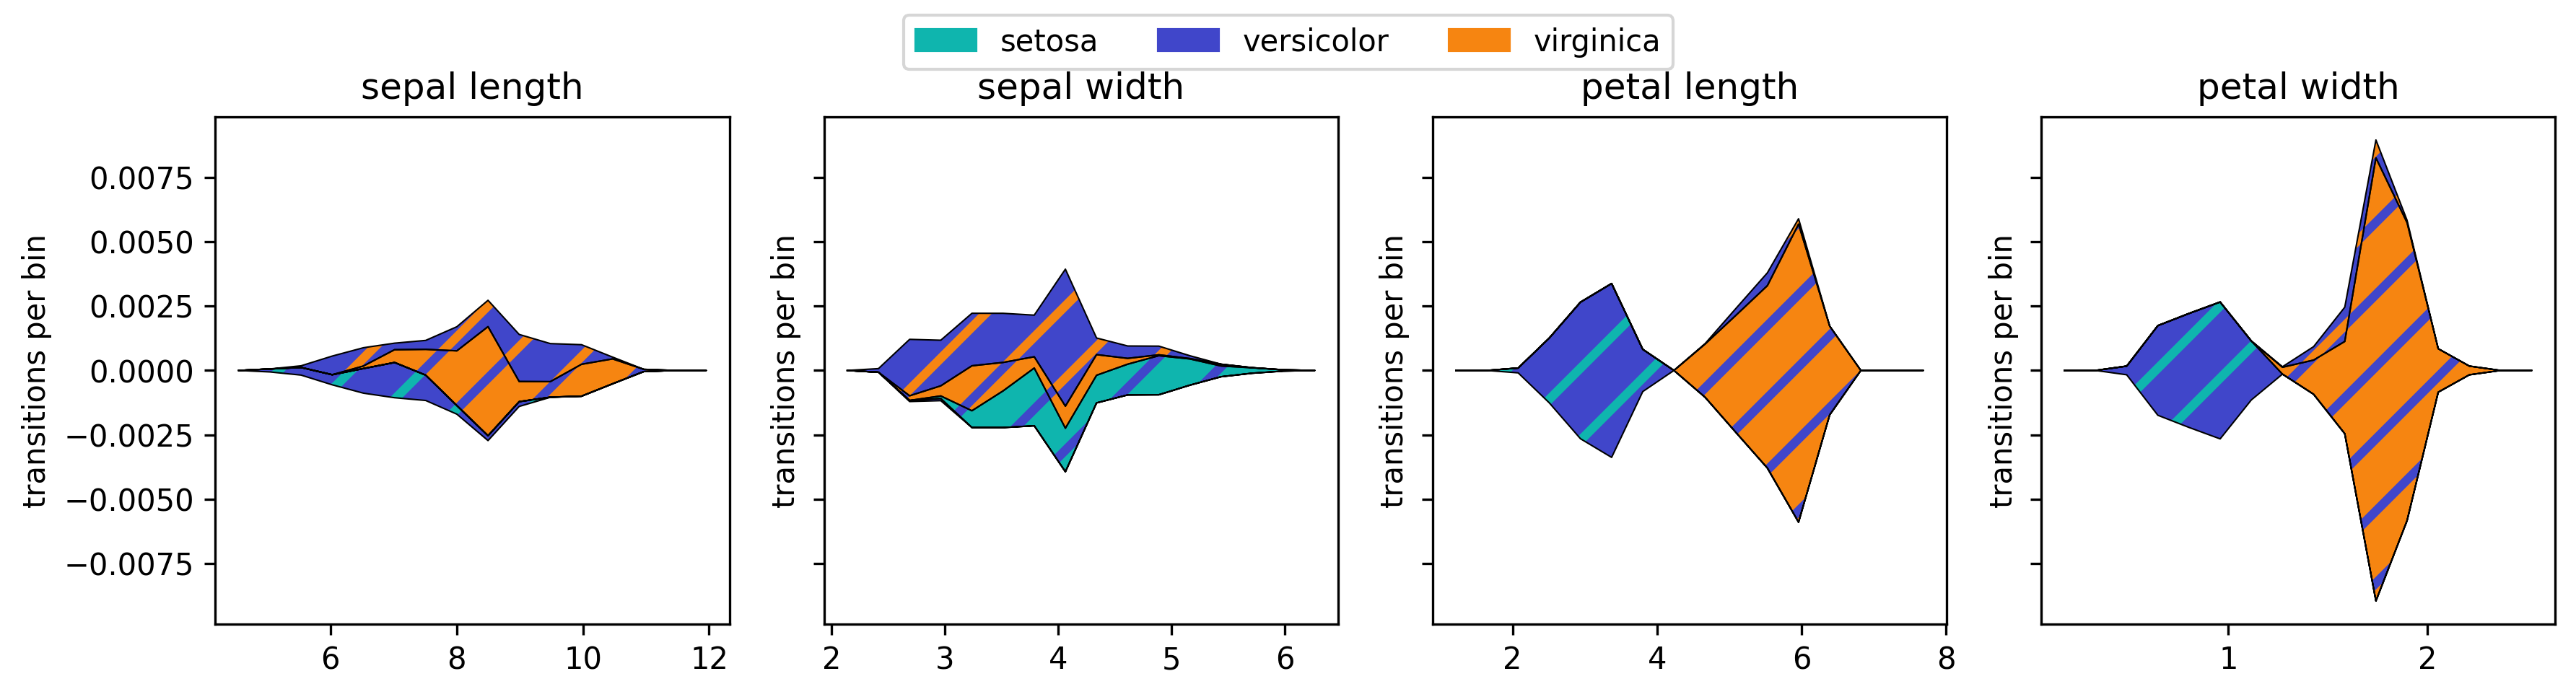

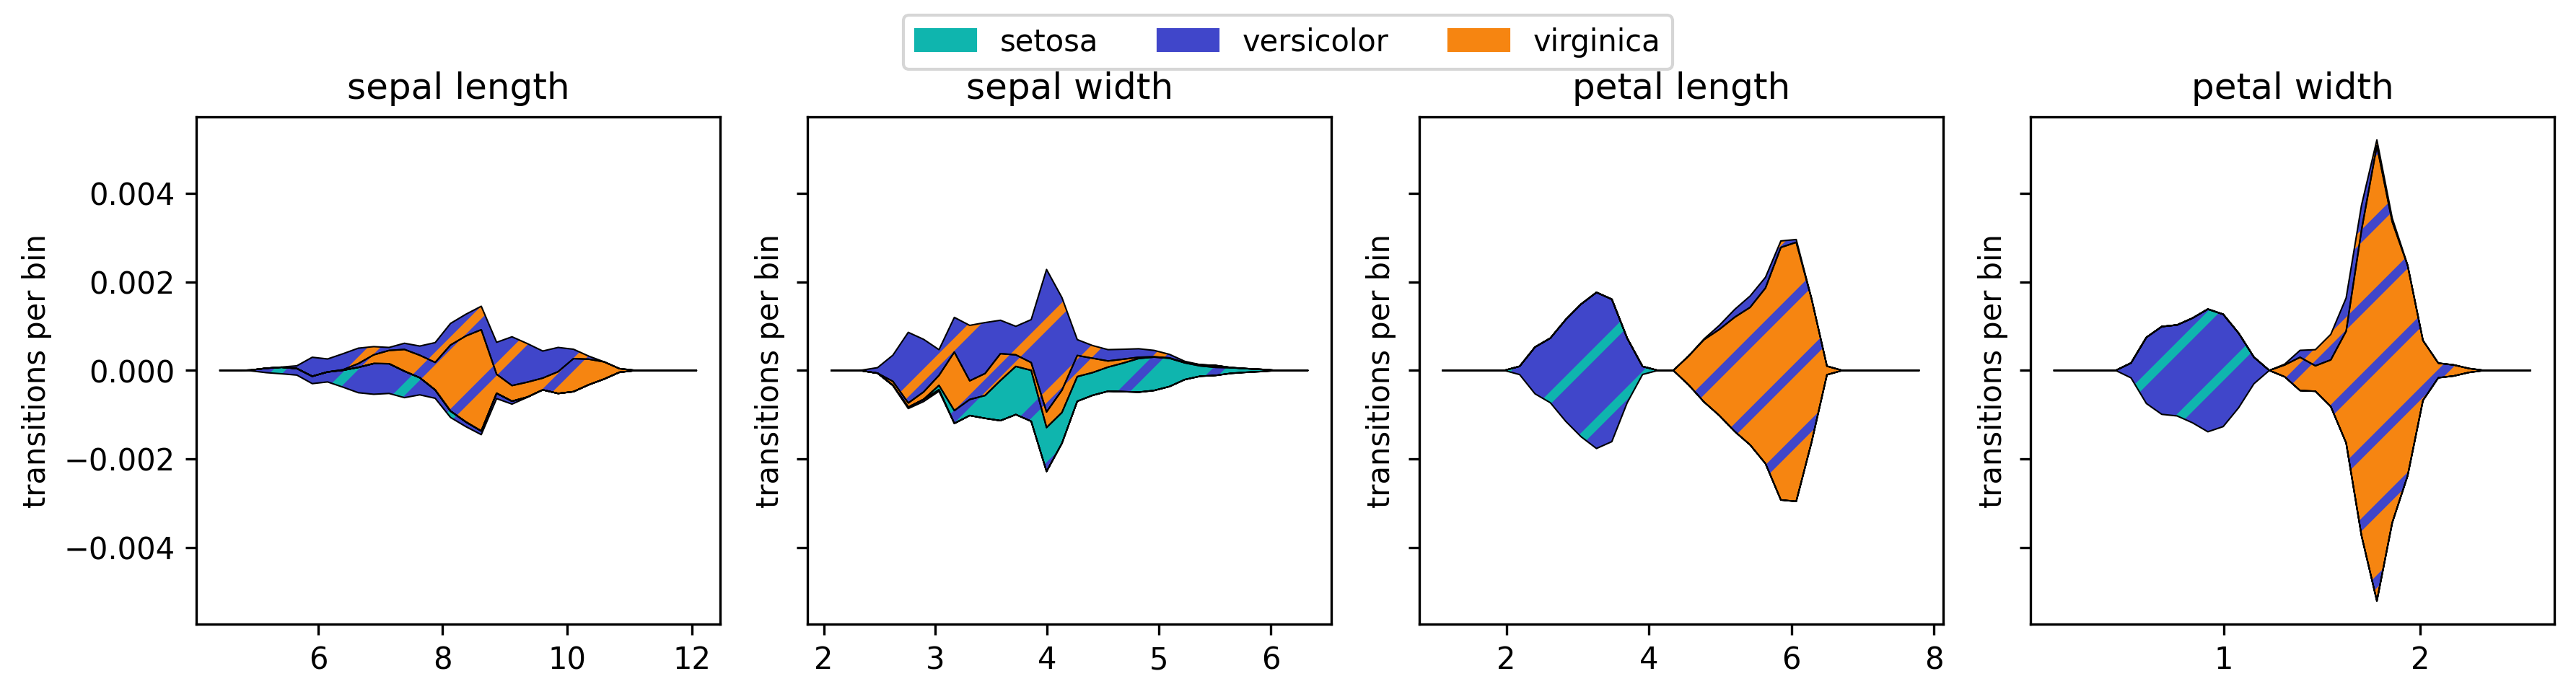

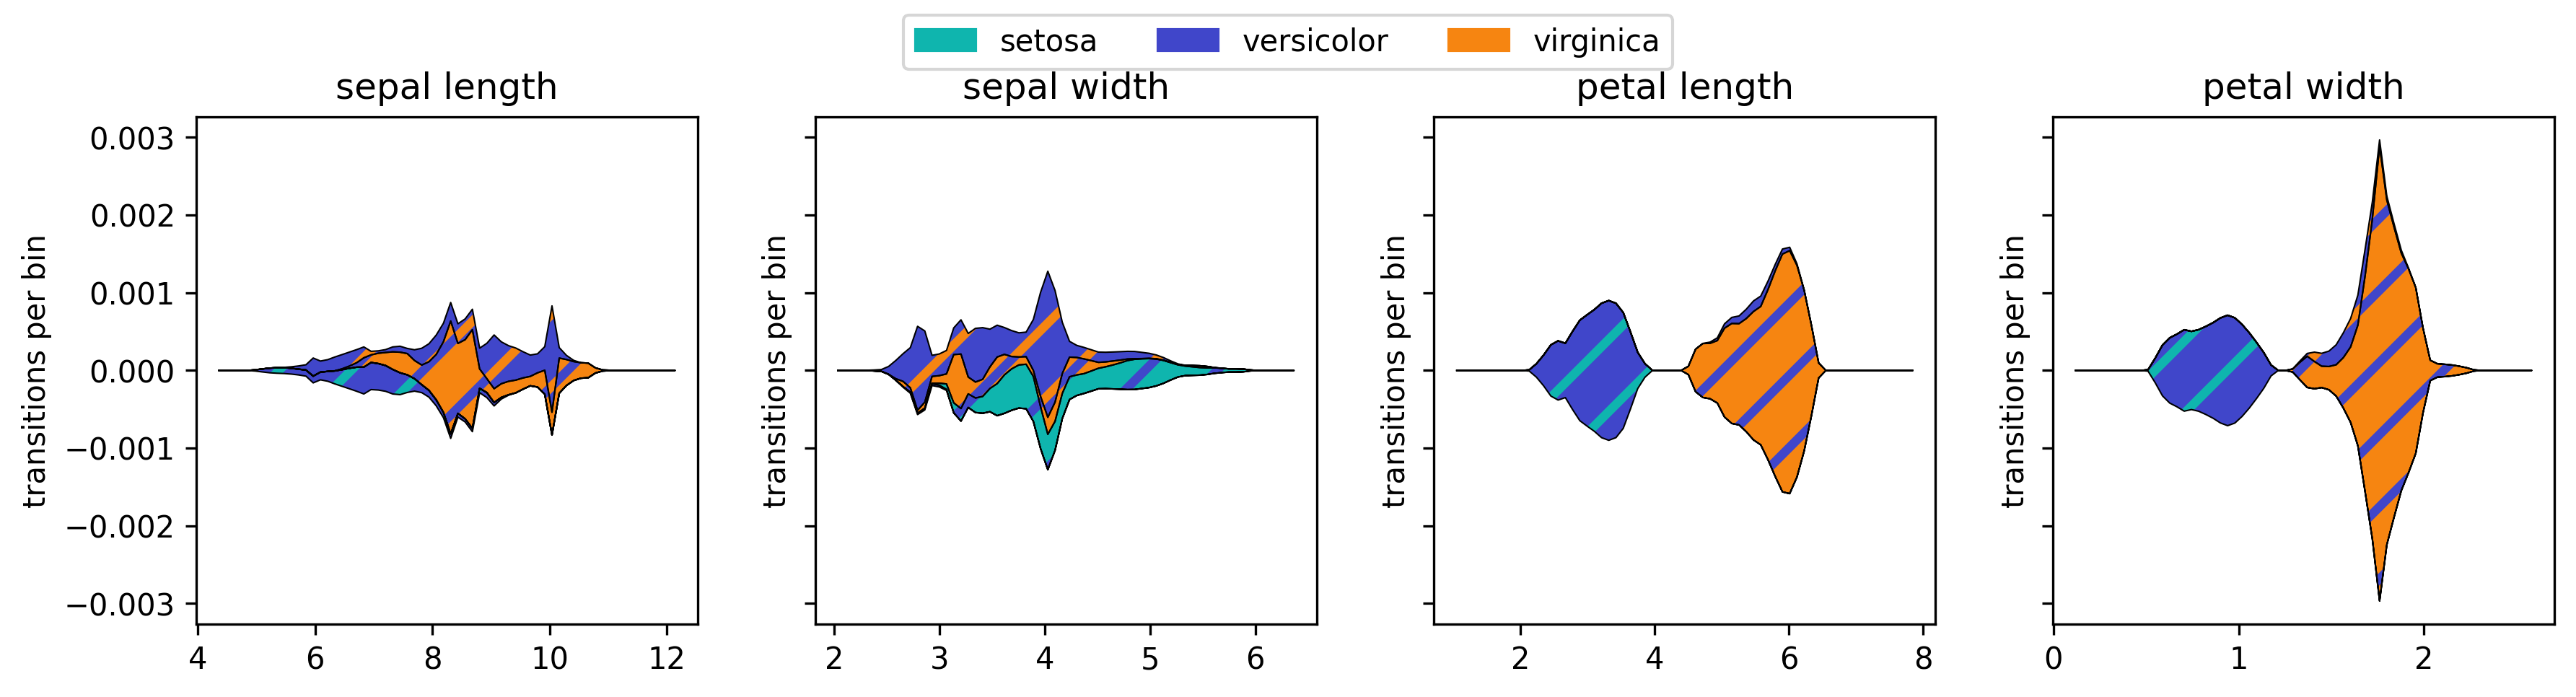

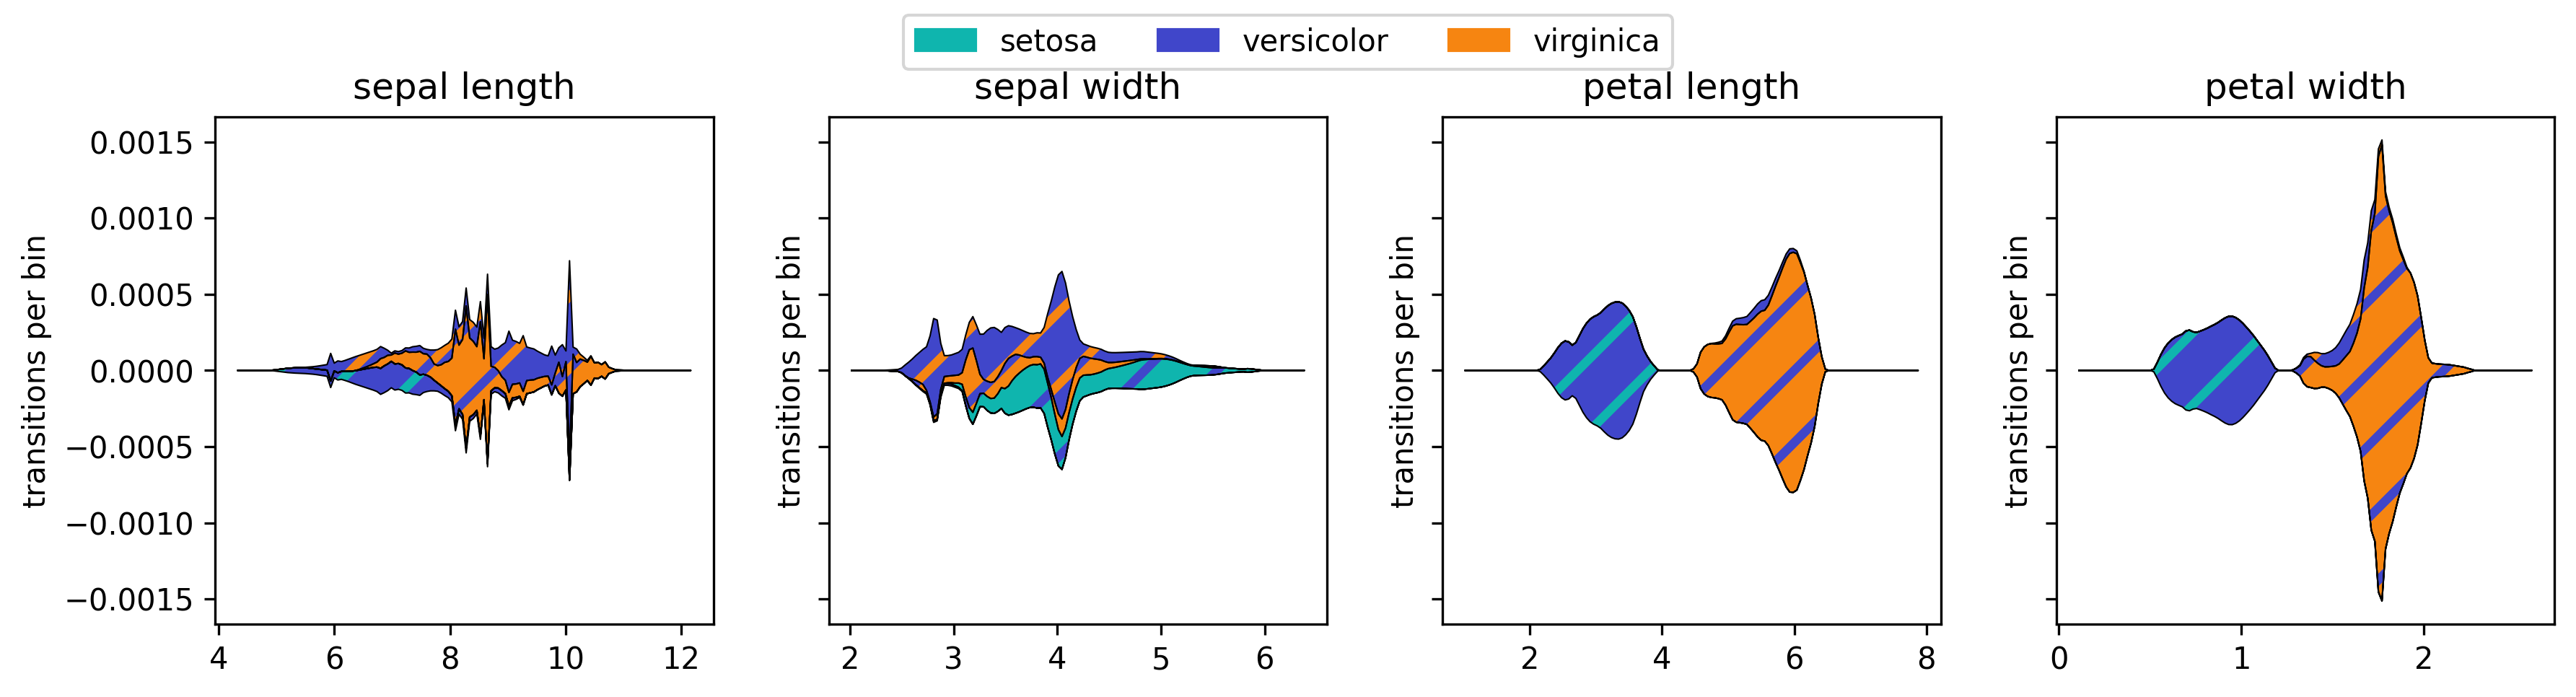

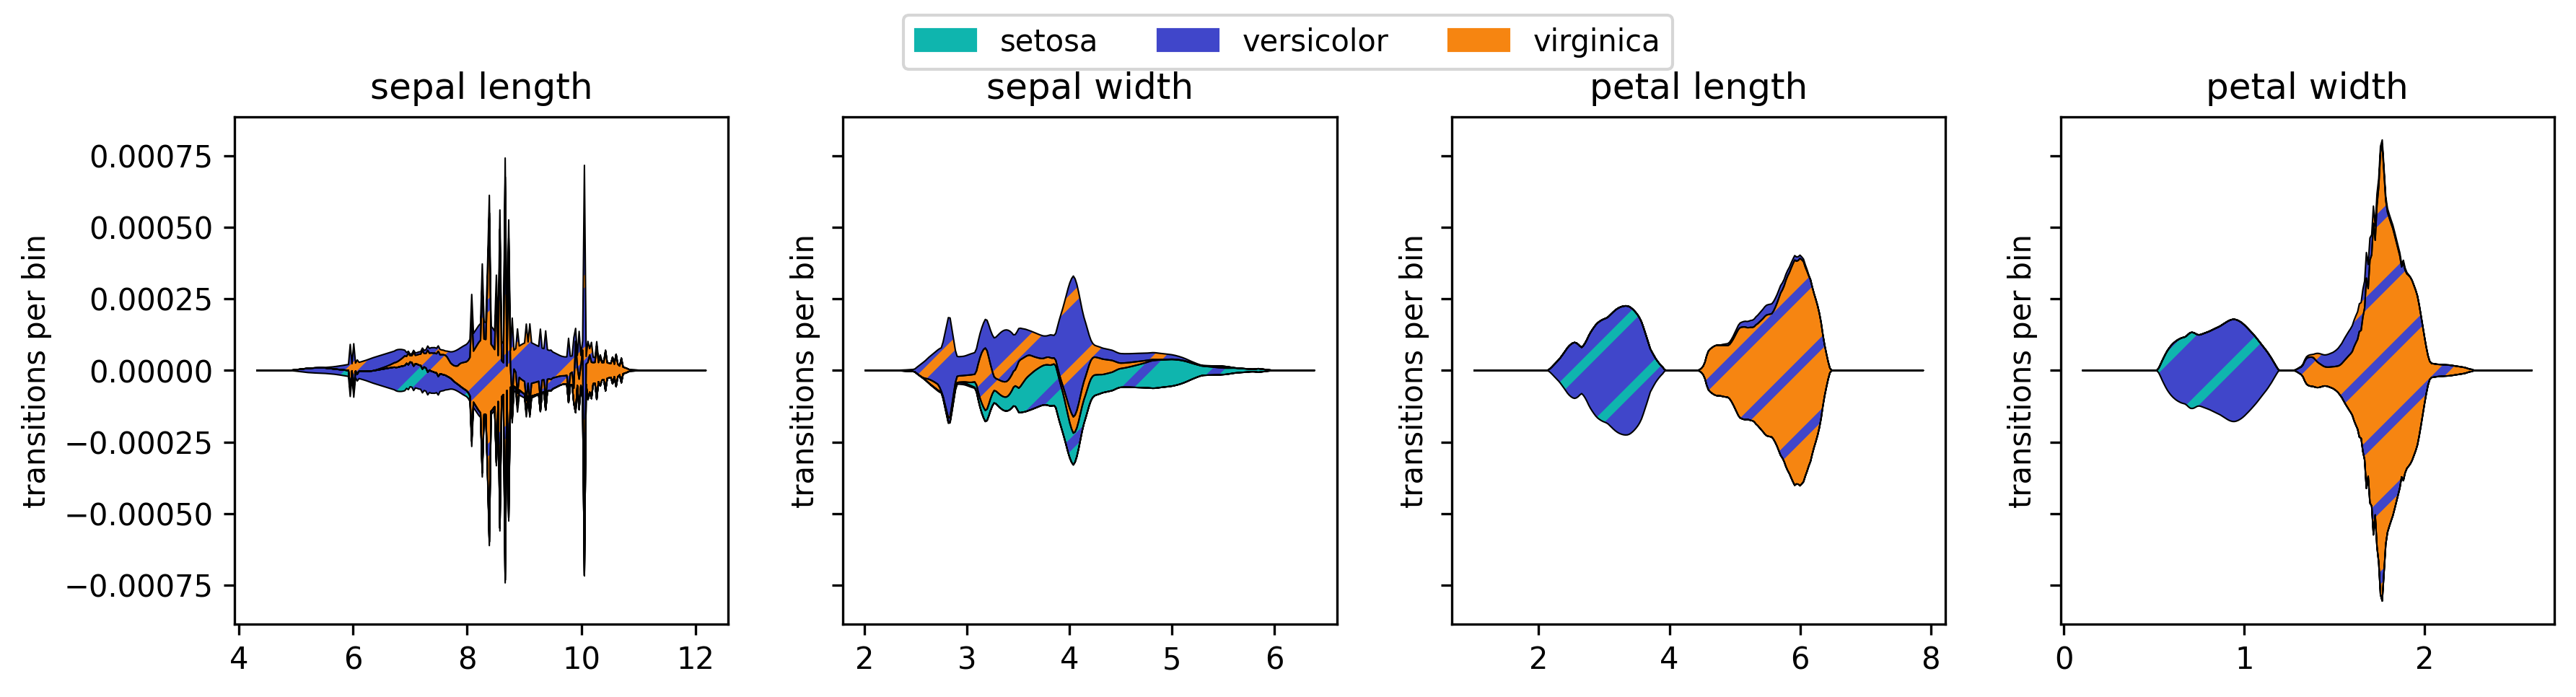

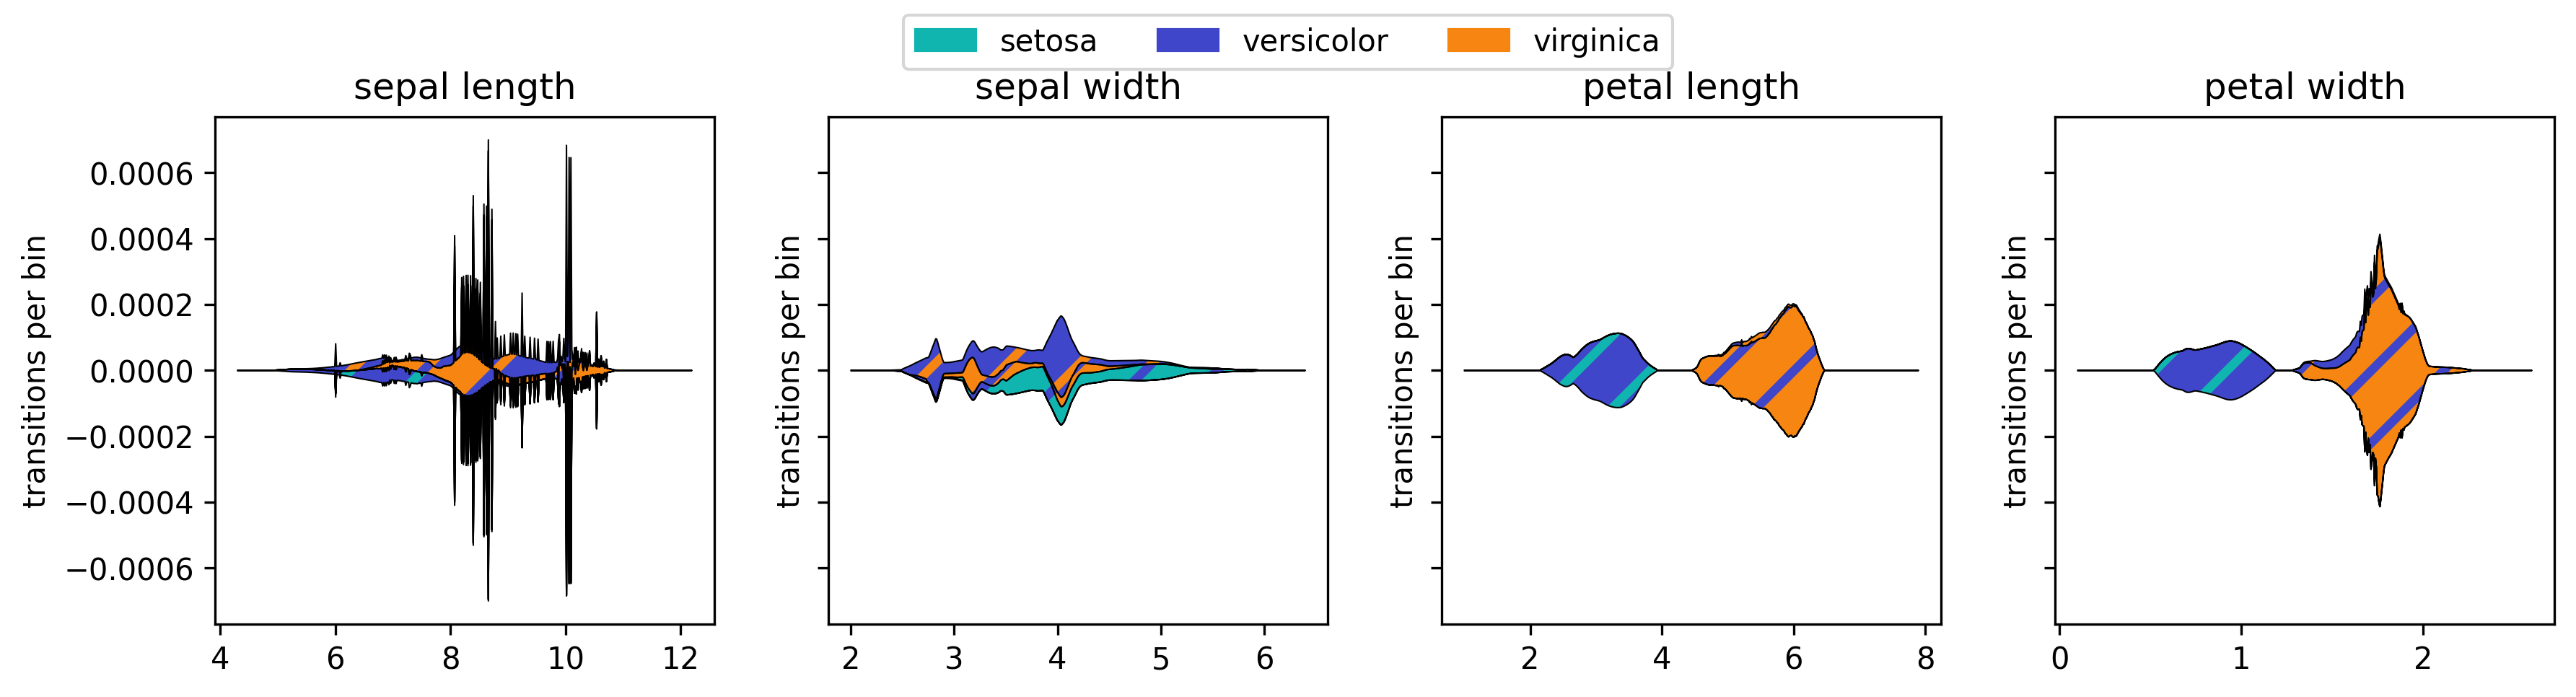

In [115]:
for r in res:
    rec_sample_points = r[1][1][-1]
    sens_matrix_list = r[1][1][0]
    timings = r[1][0]
    f = plot_sens_matrix_list(sample_points=rec_sample_points, sens_matrix_list=sens_matrix_list, **_plot_sens_matrix_list_kwargs)

    old_hatch_width = plt.rcParams["hatch.linewidth"]
    plt.rcParams["hatch.linewidth"] = _plot_sens_matrix_list_kwargs["stackplot_hatch_linewidth"]
    f.savefig(f"bins-{r[0]}-bw_experiments_plot_sens_matrix_list.pdf", **_save_fig_kwargs)
    plt.rcParams["hatch.linewidth"] = old_hatch_width

n_samples_per_dim: 1, repeats: 1, timings average: 3.01, std: 0.00, median: 3.01, bandwidths: [1.0, 1.0, 1.0, 1.0]


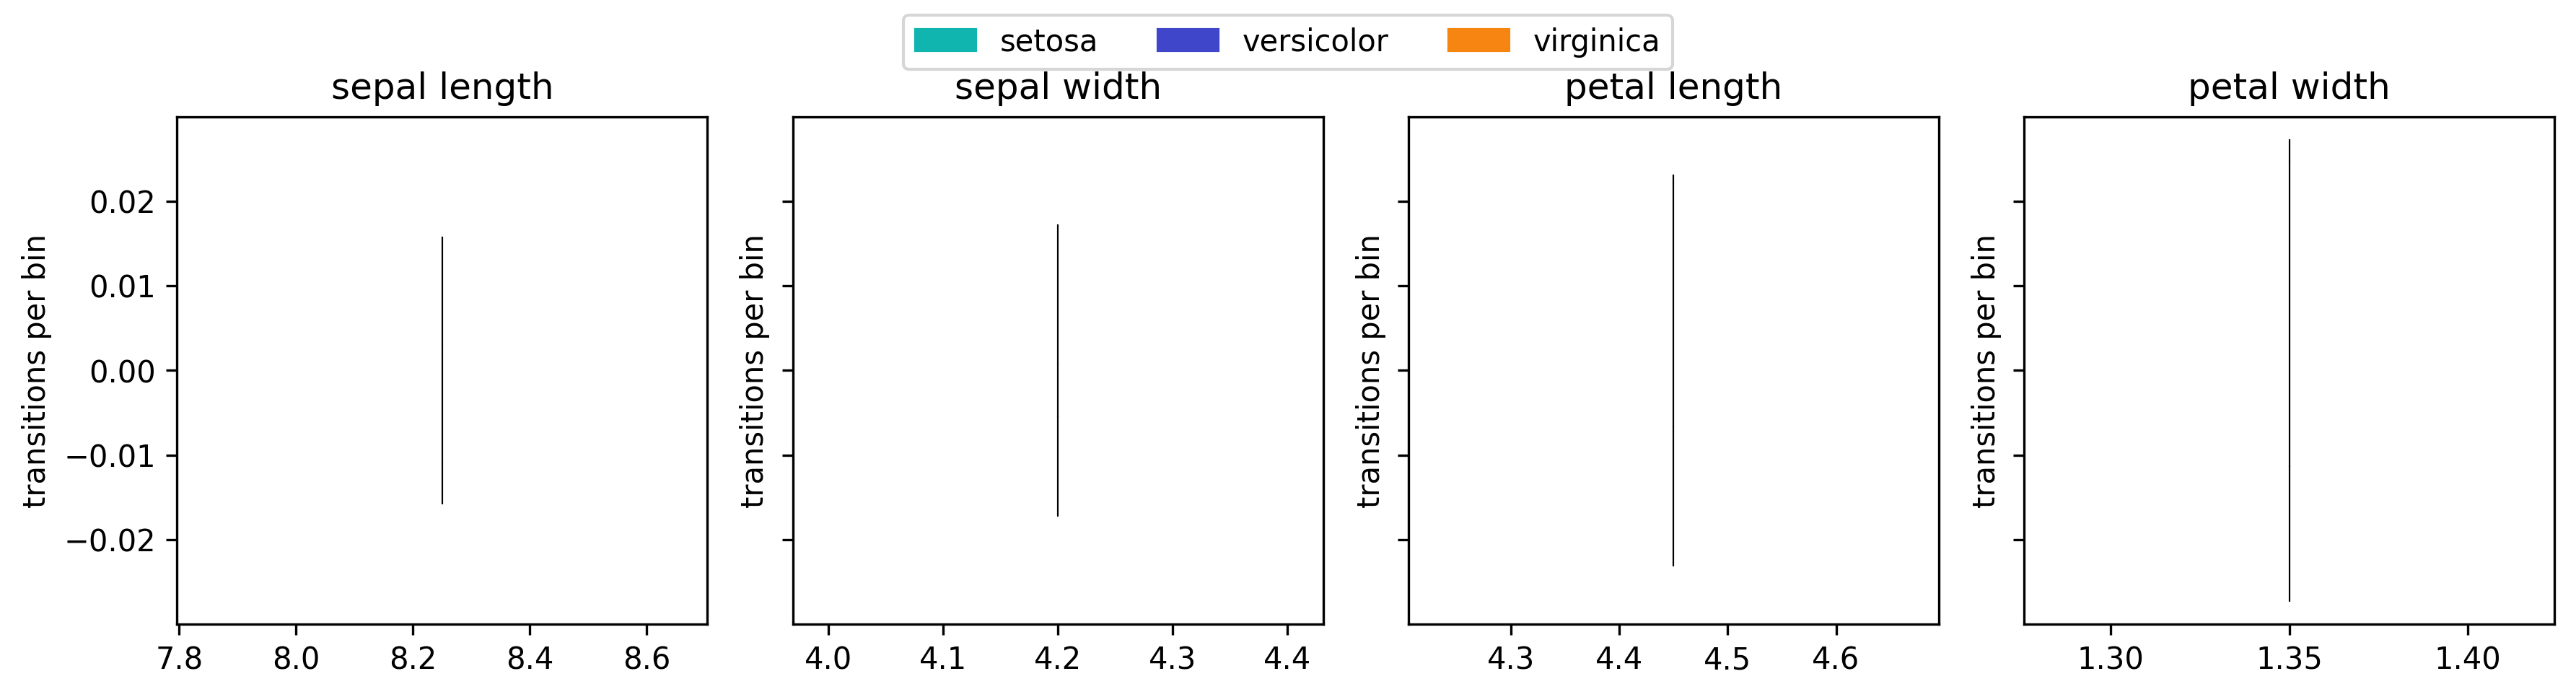

n_samples_per_dim: 2, repeats: 1, timings average: 2.55, std: 0.00, median: 2.55, bandwidths: [0.5, 0.5, 0.5, 0.5]


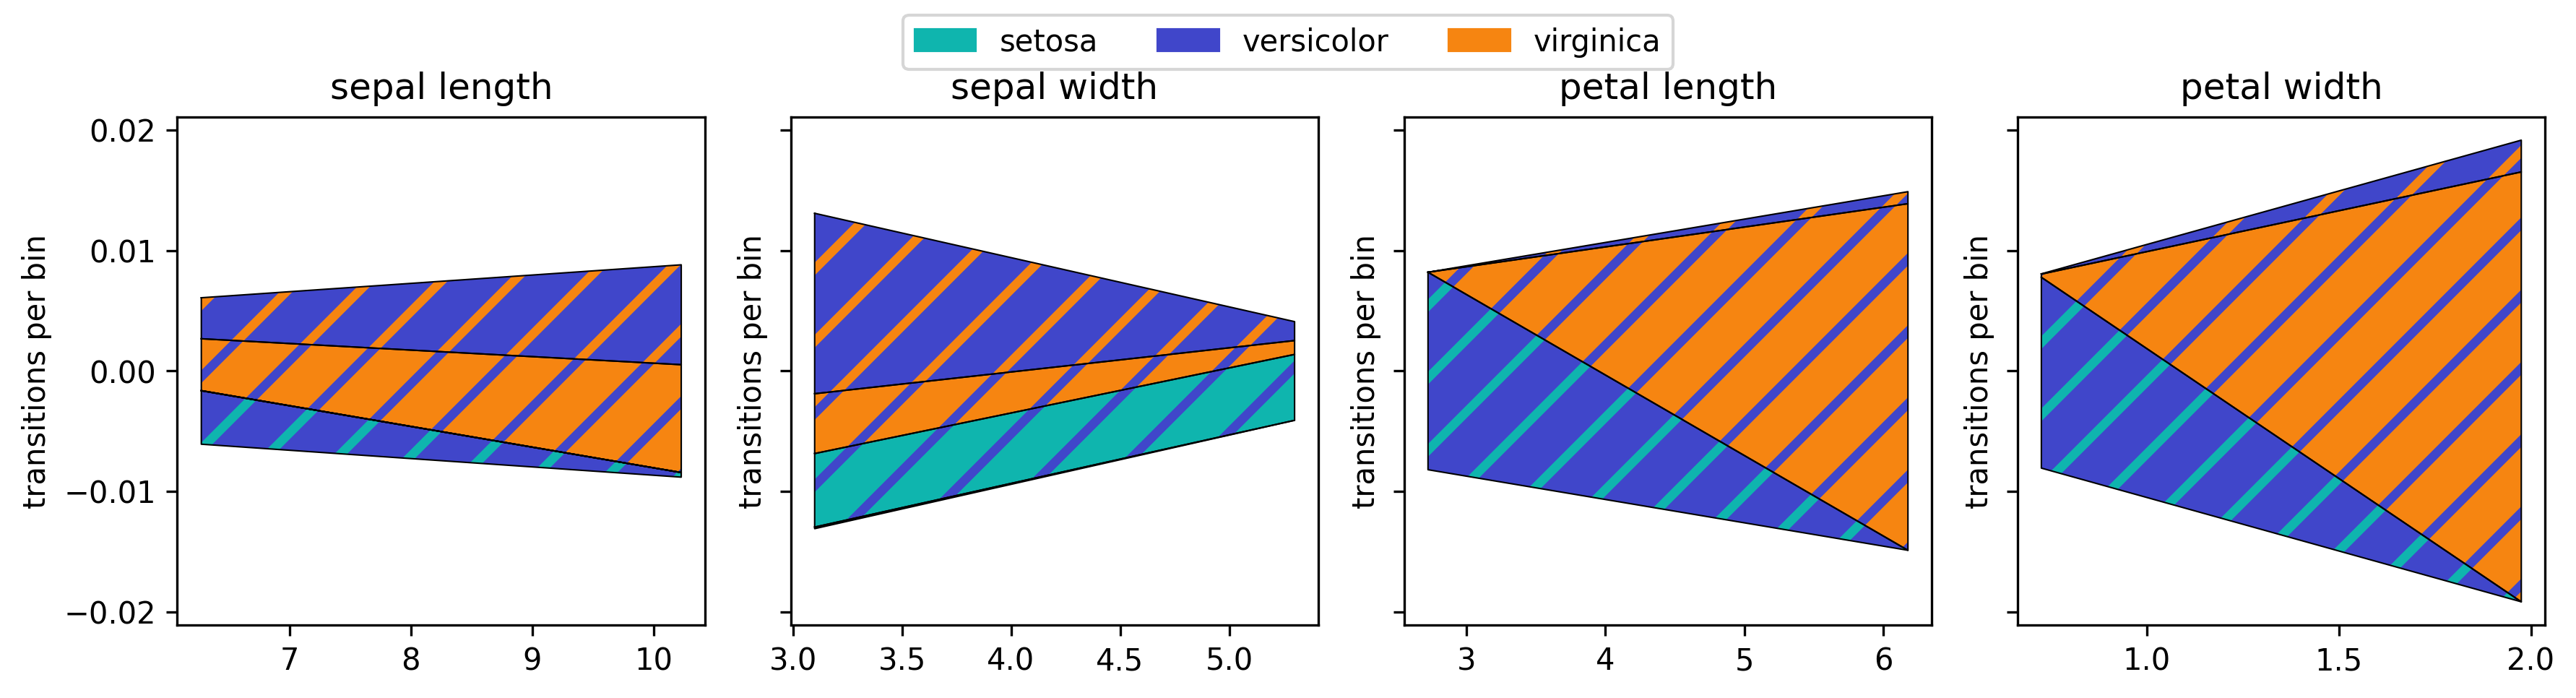

n_samples_per_dim: 4, repeats: 1, timings average: 3.07, std: 0.00, median: 3.07, bandwidths: [0.25, 0.25, 0.25, 0.25]


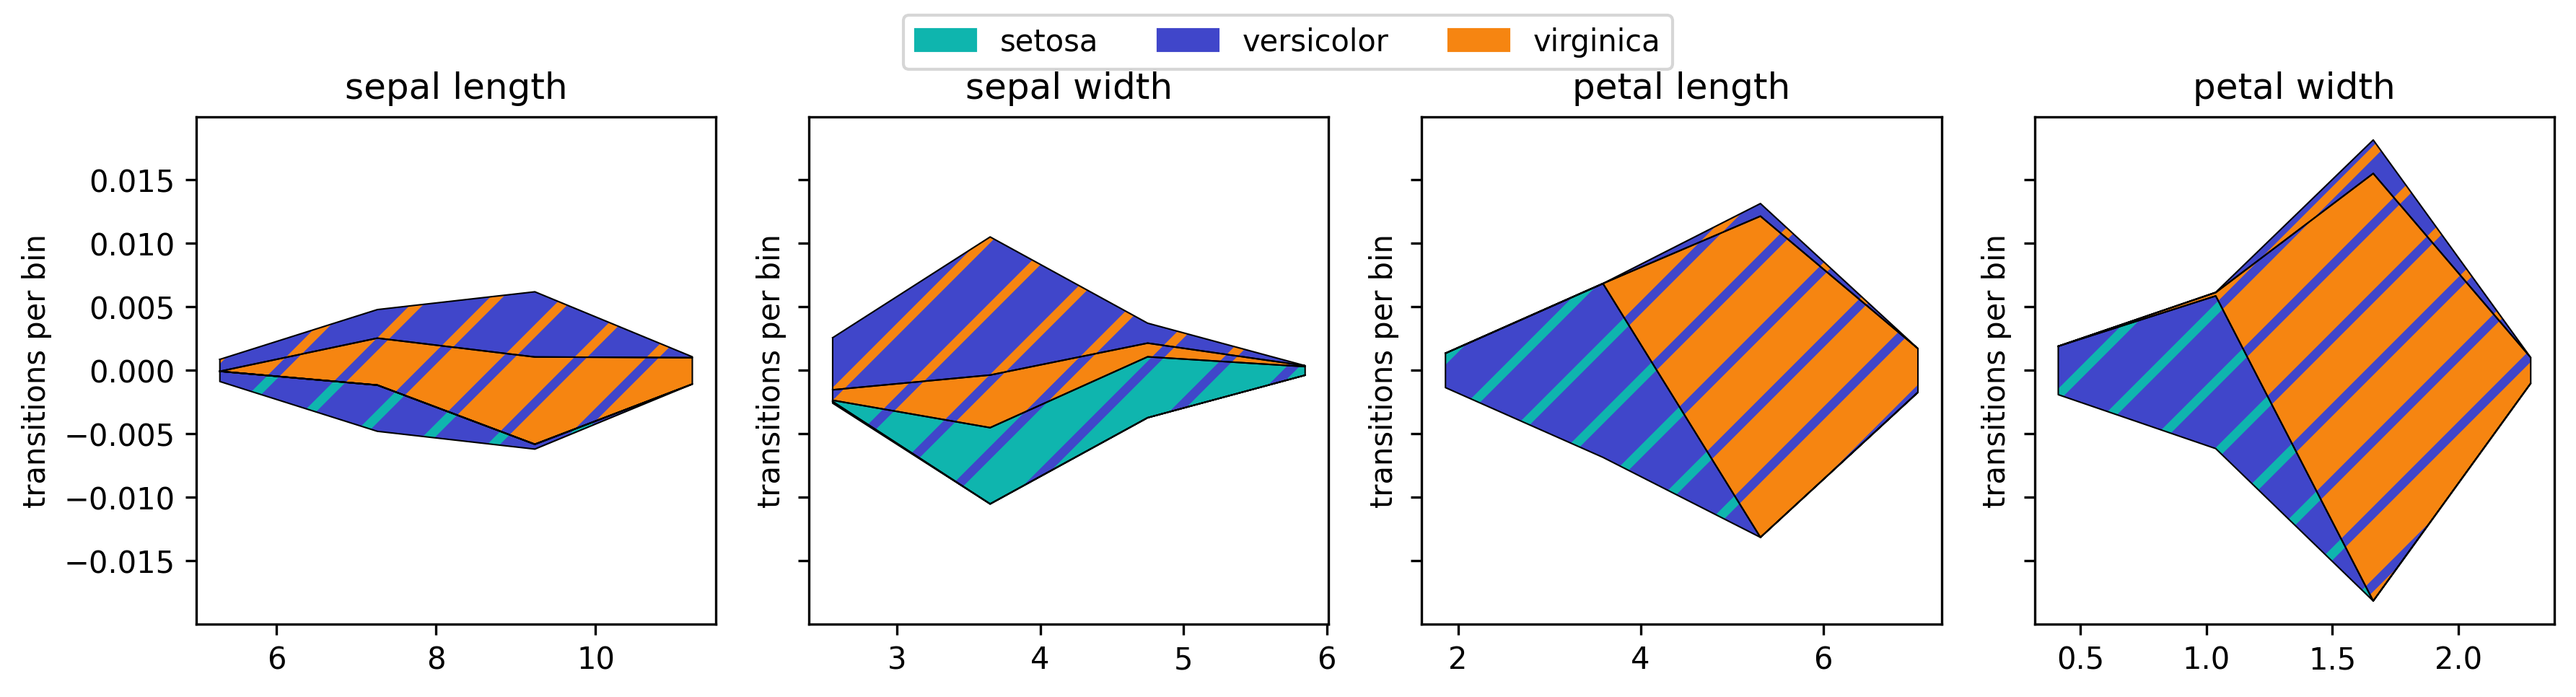

n_samples_per_dim: 8, repeats: 1, timings average: 3.86, std: 0.00, median: 3.86, bandwidths: [0.125, 0.125, 0.125, 0.125]


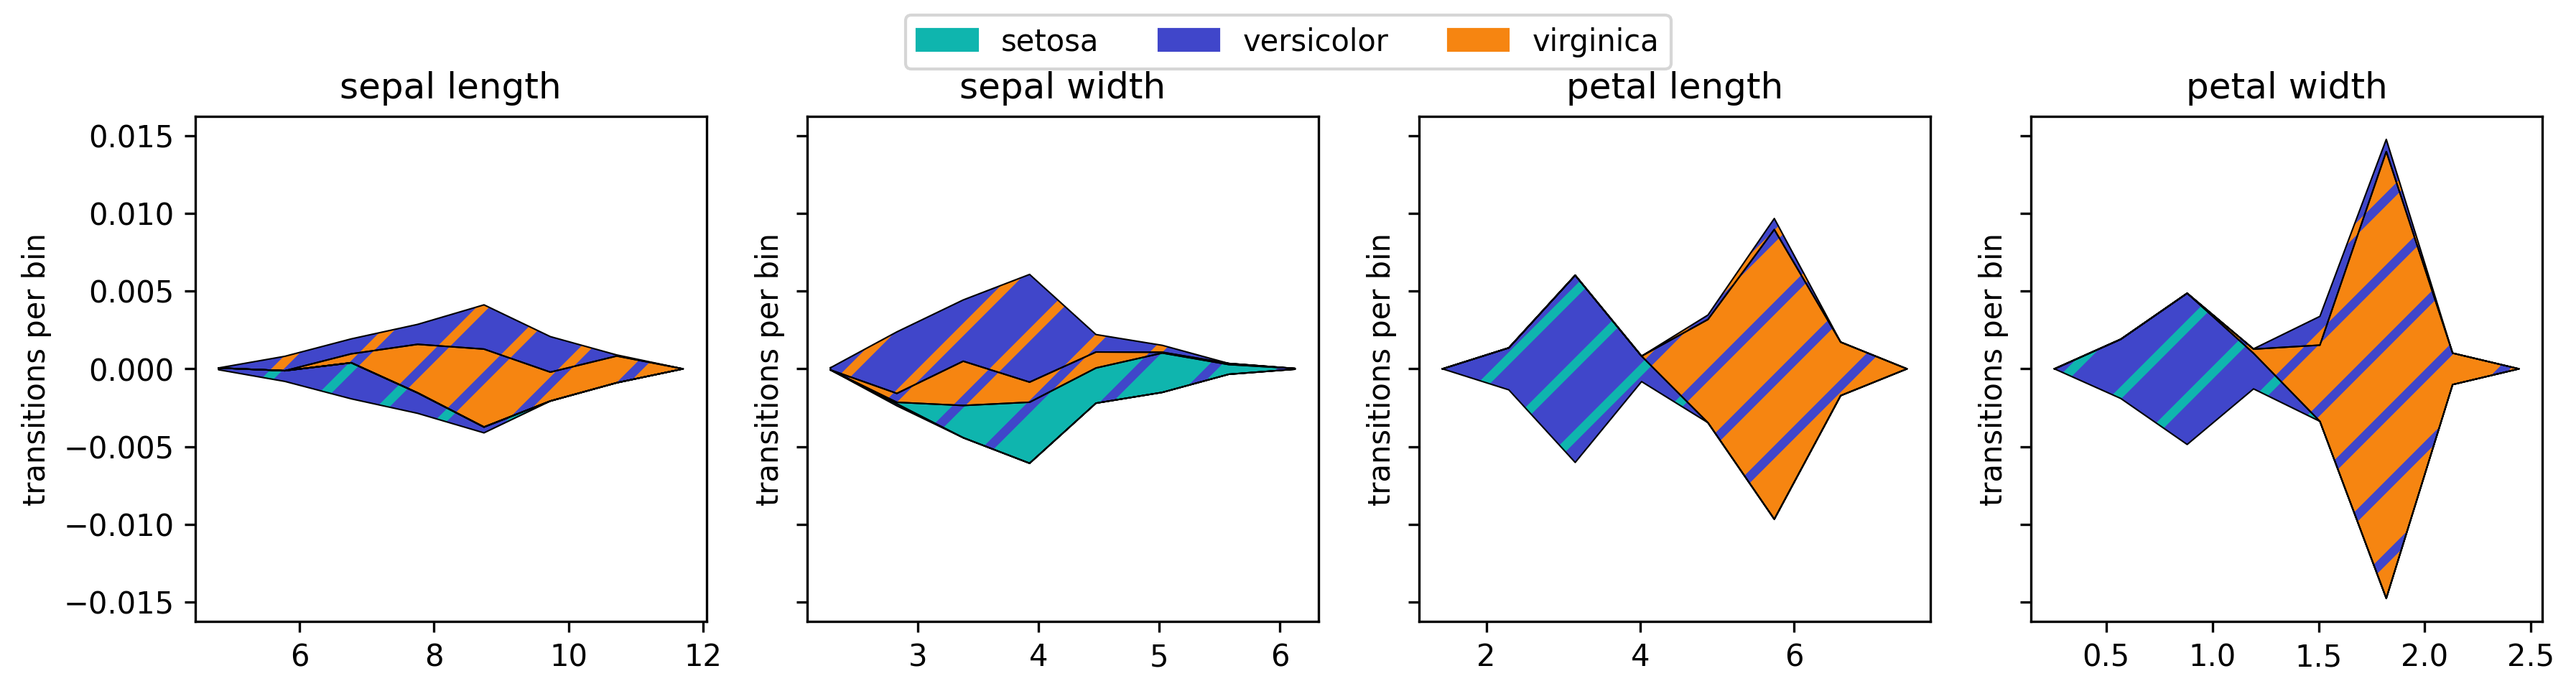

n_samples_per_dim: 16, repeats: 1, timings average: 5.48, std: 0.00, median: 5.48, bandwidths: [0.0625, 0.0625, 0.0625, 0.0625]


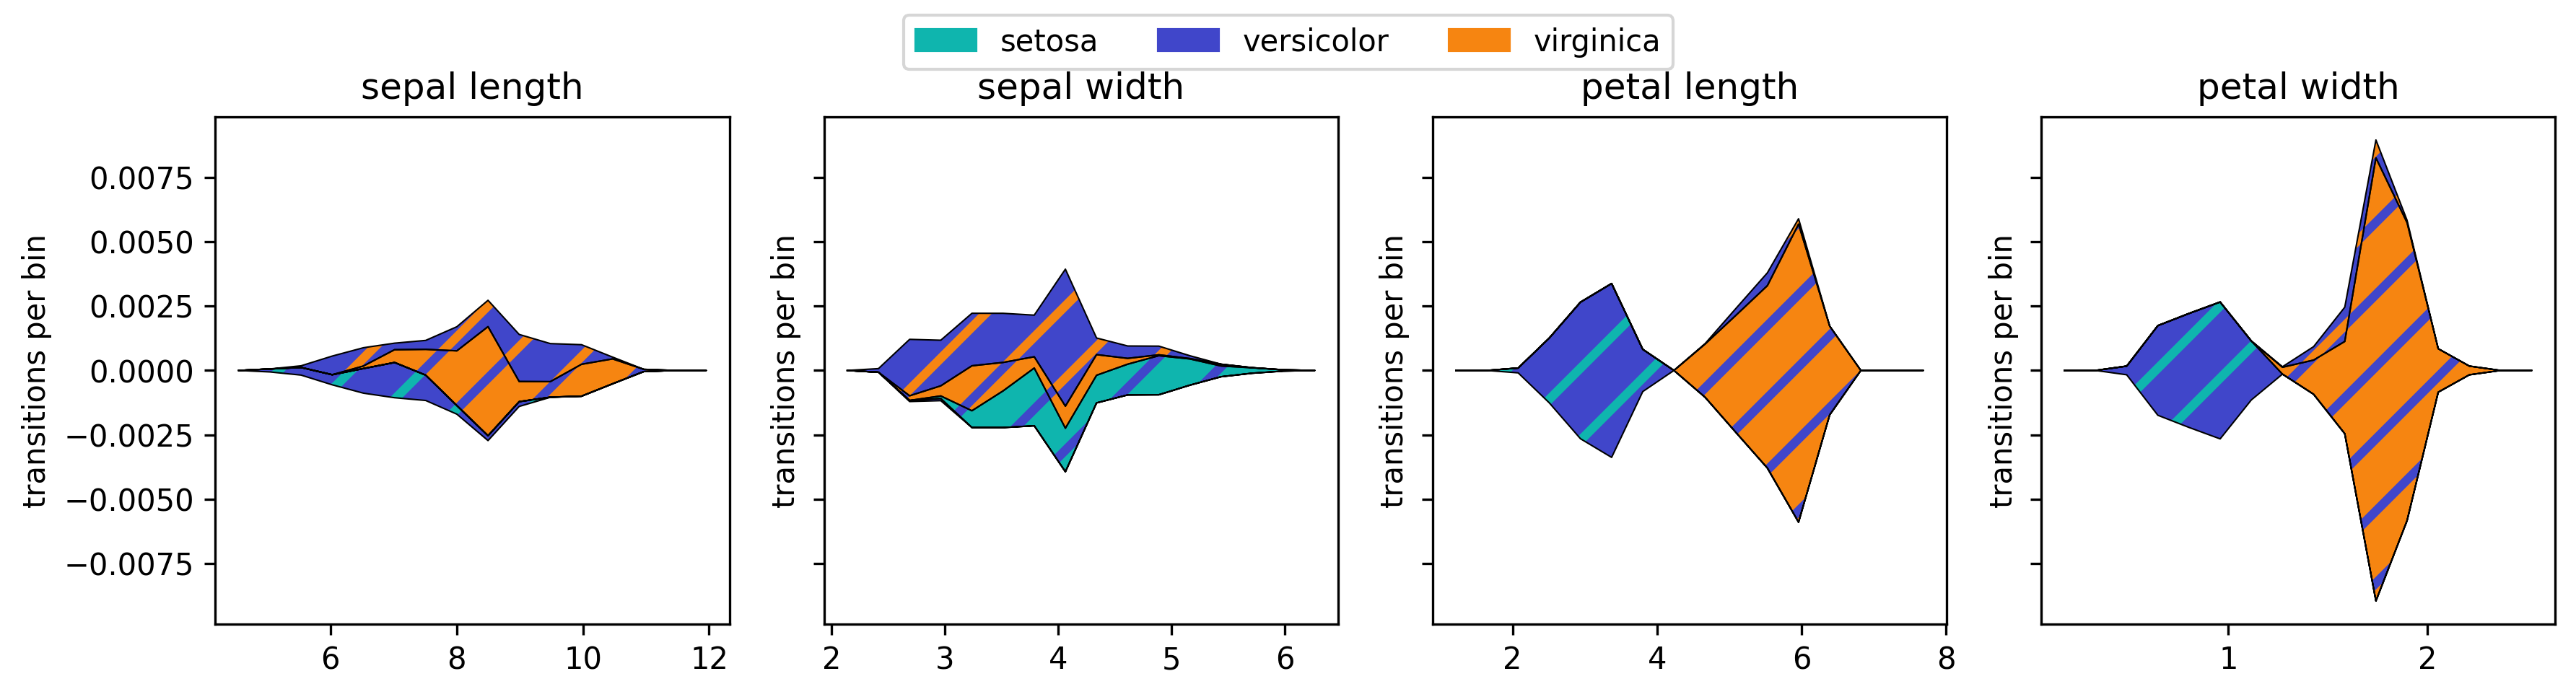

n_samples_per_dim: 32, repeats: 1, timings average: 8.43, std: 0.00, median: 8.43, bandwidths: [0.03125, 0.03125, 0.03125, 0.03125]


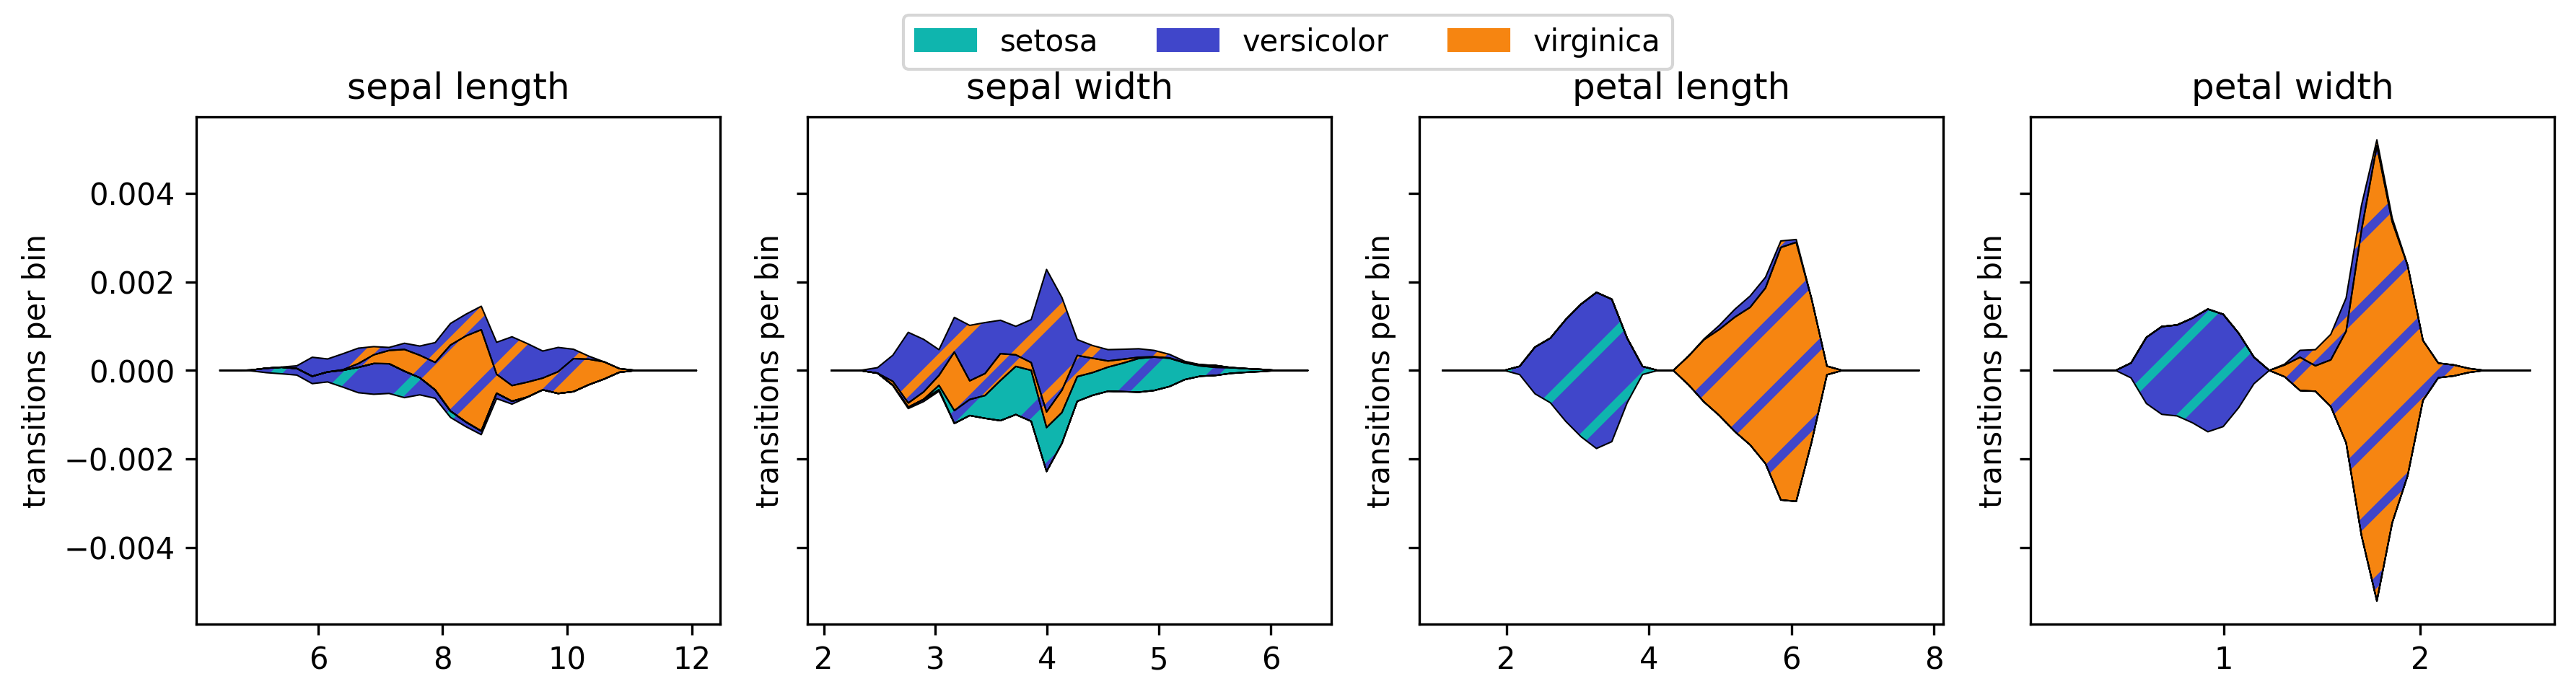

n_samples_per_dim: 64, repeats: 1, timings average: 14.72, std: 0.00, median: 14.72, bandwidths: [0.015625, 0.015625, 0.015625, 0.015625]


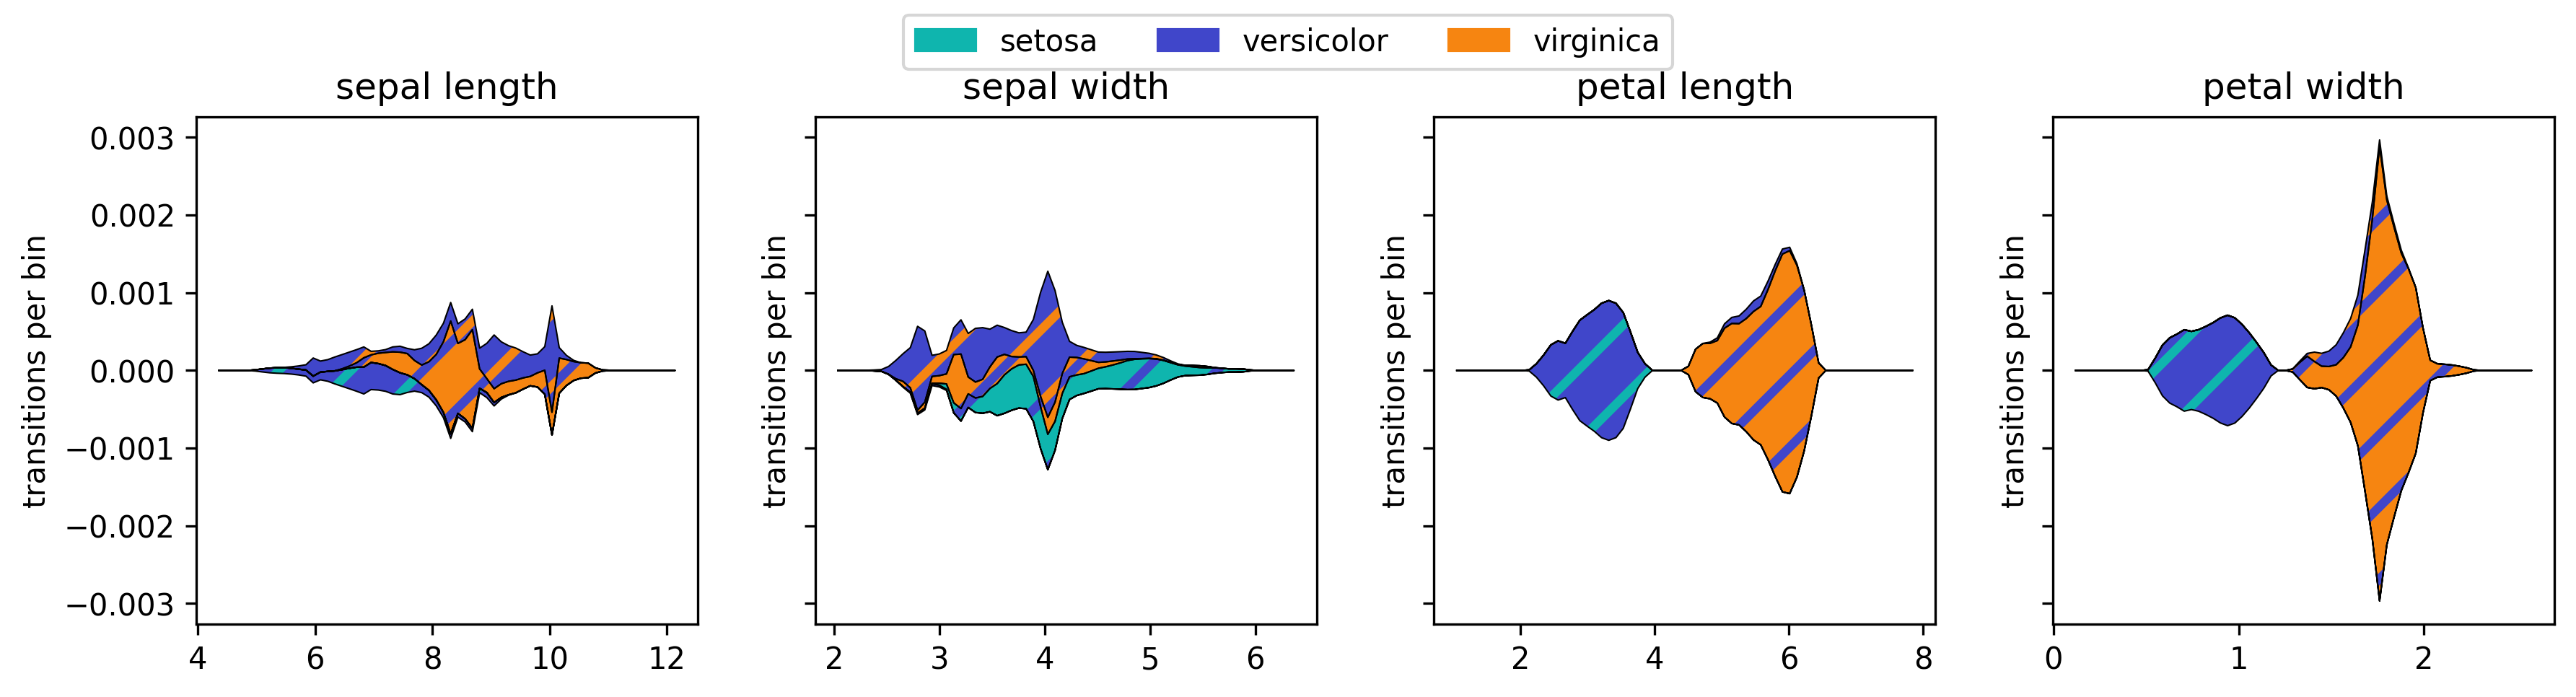

n_samples_per_dim: 128, repeats: 1, timings average: 26.04, std: 0.00, median: 26.04, bandwidths: [0.0078125, 0.0078125, 0.0078125, 0.0078125]


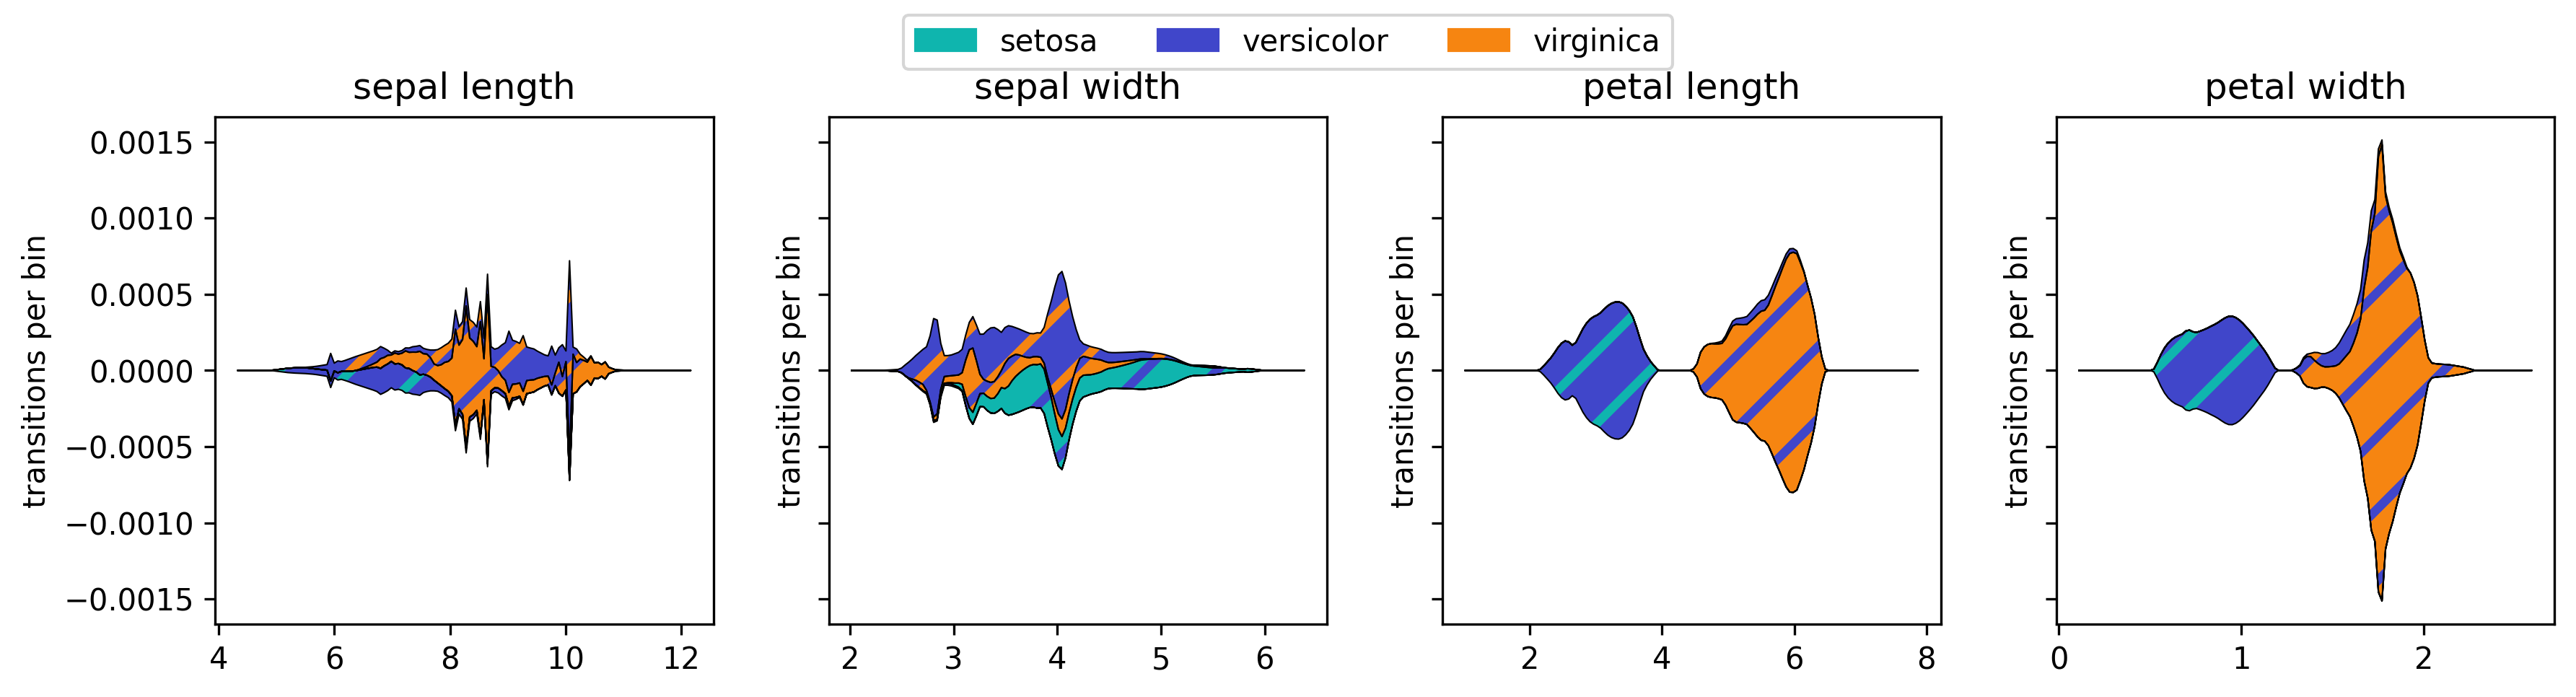

n_samples_per_dim: 256, repeats: 1, timings average: 50.58, std: 0.00, median: 50.58, bandwidths: [0.00390625, 0.00390625, 0.00390625, 0.00390625]


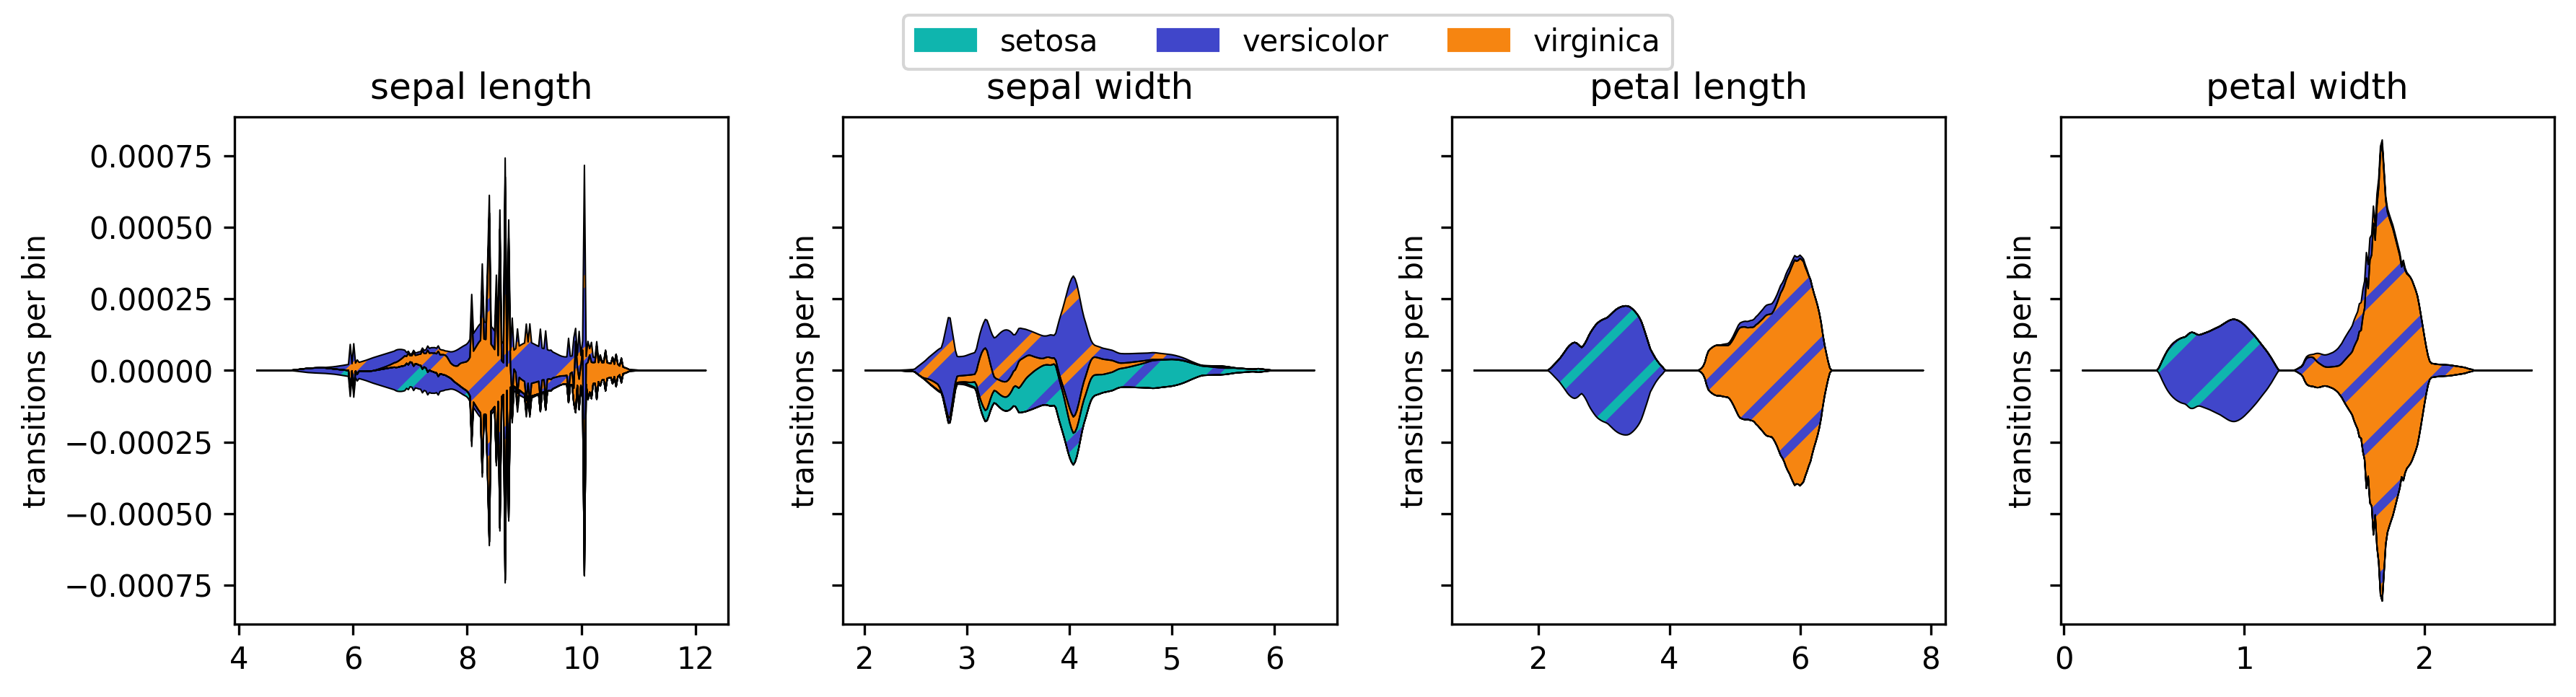

n_samples_per_dim: 512, repeats: 1, timings average: 99.64, std: 0.00, median: 99.64, bandwidths: [0.001953125, 0.001953125, 0.001953125, 0.001953125]


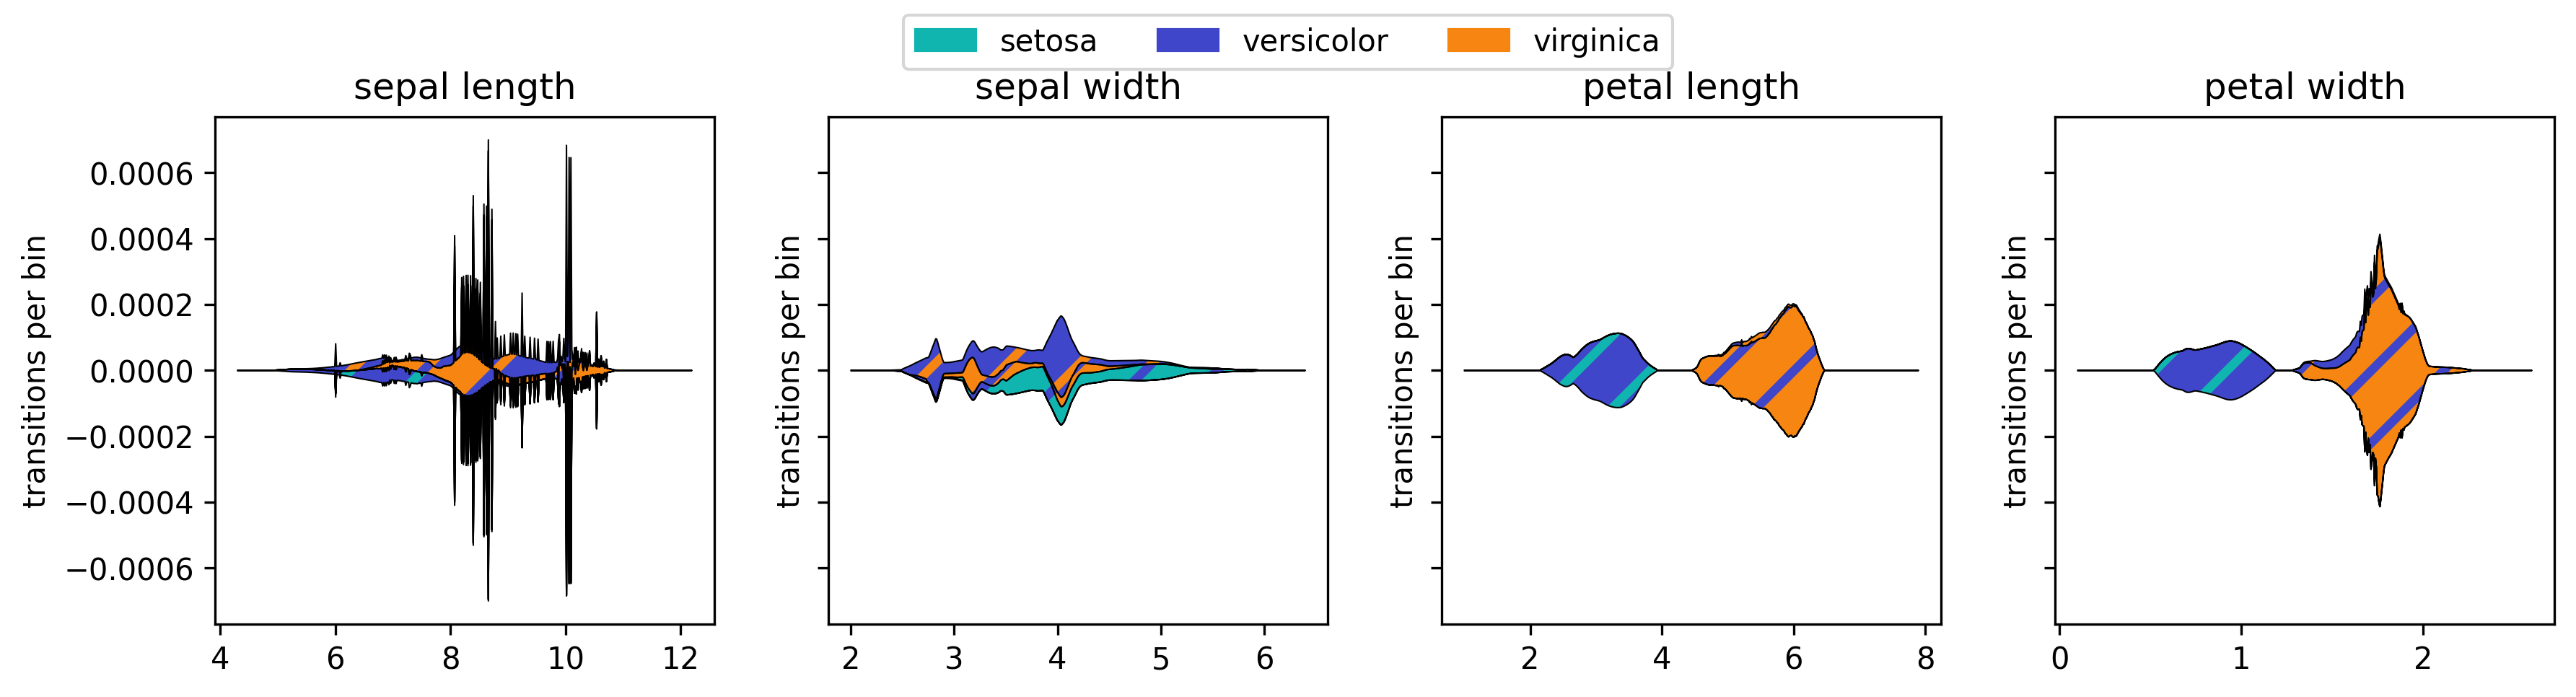

In [116]:
# bandwidth experiment
res2 = []

for n_samples_per_dim_ in [(2 ** i) for i in range(10)]:
    res_ = bandwidth_experiment(n_samples_per_dim_, repeat=1)
    res2.append((n_samples_per_dim_, res_))

C:\Users\bauerrn\AppData\Local\Temp\ipykernel_30732\2406550916.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


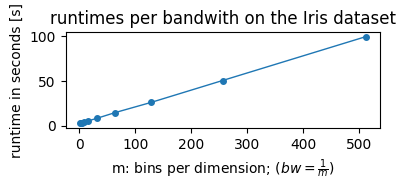

In [ ]:
fig = plt.figure(figsize=(4, 2))
ax = fig.gca()

x = [r[0] for r in res2]
bws = 1 / np.array(x)

ys = np.stack([r[1][0] for r in res2])
avgs = np.average(ys, 1)
mds = np.median(ys, 1)
stds = np.std(ys, 1)

ax.plot(x, avgs, linewidth=1)
ax.scatter(x, avgs, s=2**4)
# ax.scatter(x, mds, s=2**4, marker="x")
# ax.errorbar(x, avgs, yerr=stds, fmt='none')


ax.set_xlabel(r"m: bins per dimension; ($bw = \frac{1}{m}$)")
ax.set_ylabel("runtime in seconds [s]")

ax.set_title("runtimes per 1/bandwith on the Iris dataset")

fig.tight_layout()
fig.show()
fig.savefig("bandwidth_experiments_2.pdf")